## Set Up

In [1]:
%run D:/KIMoDIs/global-groundwater-models-main/notebooks/plots_set_up.ipynb

## Model metrics plots


In [2]:
metrics_dict = {}
MODEL_TYPE_ls = ['tft_full', 'tft_dyn', 'tft_full_interpol', 'tft_dyn_interpol', 'nhits_full', 'nhits_dyn']
# tft_full_interpol

for MODEL_TYPE in MODEL_TYPE_ls: 
    metrics_ls = []
        
    folder = os.path.join(RESULT_PATH,
                'metrics', 
                'nhits' if 'nhits' in MODEL_TYPE else 'tft',
                f'{MODEL_TYPE}',
                f'{MODEL_TYPE}_1024_{VERSION}' if 'nhits' in MODEL_TYPE else f'{MODEL_TYPE}_4096_{VERSION}'
                )
    
    # list of different versions
    init = [name for name in os.listdir(folder) if re.match('metrics_tft.*|metrics_nhits.*', name)]
    
    for i in init: 
            
        df = pd.read_feather(os.path.join(folder, i))
        
        # Add id to differentiate the initialisations
        _i = re.sub('(metrics_(nhits|tft)_)(version_.*)(.feather)', '\\3',i)
        df['init'] = _i
        df['model_type'] = MODEL_TYPE
        metrics_ls.append(df)
    
    metrics_dict[MODEL_TYPE] = metrics_ls

In [3]:
# Concat and take median over all initialisations per model_type (models with groundwater level information)
metrics_df = pd.concat(
    [pd.concat([pd.DataFrame(metrics_dict['tft_full'][i]) for i in range(len(metrics_dict['tft_full']))], 
                               ignore_index=False),
    pd.concat([pd.DataFrame(metrics_dict['tft_dyn'][i]) for i in range(len(metrics_dict['tft_dyn']))], 
                              ignore_index=False),
    pd.concat([pd.DataFrame(metrics_dict['nhits_full'][i]) for i in range(len(metrics_dict['nhits_full']))], 
                              ignore_index=False),
    pd.concat([pd.DataFrame(metrics_dict['nhits_dyn'][i]) for i in range(len(metrics_dict['nhits_dyn']))], 
                              ignore_index=False)]
)

# Median agg over all intialisations for the NSE for each site/well
metrics_agg = metrics_df.groupby(['model_type', 'proj_id', 'horizon'])[['NSE', 'RMSE', 'rMBE', 'Interval Score']].median().reset_index()
# pq.write_table(pa.Table.from_pandas(metrics_agg), os.path.join(RESULT_PATH, 'metrics', 'median_metrics_all_init.parquet'))

# Subset for h = [1, 12]
metrics_subset = metrics_agg[metrics_agg['horizon'].isin([1, 12])][['proj_id', 'NSE', 'RMSE', 'rMBE', 'Interval Score', 'horizon', 'model_type']]
# metrics_nhits_v1[(metrics_nhits_v1 == -np.inf).any(axis=1)]
# print(metrics_subset['NSE'].isinf())
# print(metrics_subset[metrics_subset['NSE'].isna()])
# print(metrics_subset[metrics_subset['NSE']<-1])

In [4]:
# 9 sites with basically no variation
# Remove NA, INF
metrics_subset['NSE'] = metrics_subset['NSE'].replace(-np.inf, np.nan)
metrics_subset = metrics_subset.dropna(subset=['NSE'])
metrics_subset['RMSE'] = metrics_subset['RMSE'].replace(-np.inf, np.nan)
metrics_subset = metrics_subset.dropna(subset=['RMSE'])
metrics_subset['rMBE'] = metrics_subset['rMBE'].replace(-np.inf, np.nan)
metrics_subset = metrics_subset.dropna(subset=['rMBE'])
metrics_subset['Interval Score'] = metrics_subset['Interval Score'].replace(-np.inf, np.nan)
metrics_subset = metrics_subset.dropna(subset=['Interval Score'])

# Save 
# pq.write_table(pa.Table.from_pandas(metrics_subset), os.path.join(RESULT_PATH, 'metrics', 'median_metrics_subset.parquet'))

metrics_subset.groupby(['model_type', 'horizon'])[['NSE', 'RMSE', 'rMBE', 'Interval Score']].median()

metric                  NSE    RMSE     rMBE  Interval Score
model_type horizon                                          
nhits_dyn  1        0.91950  0.0550 -0.00800         1.26200
           12       0.47325  0.1365  0.07400         3.68100
nhits_full 1        0.92150  0.0540  0.00050         1.18900
           12       0.50200  0.1345  0.07650         3.88500
tft_dyn    1        0.90600  0.0600  0.01950         1.62400
           12       0.34850  0.1545  0.08825         4.40700
tft_full   1        0.91050  0.0580  0.01250         1.53600
           12       0.34450  0.1535  0.13025         4.44825

In [5]:
# NSE by federal state
metrics_subset.loc[:,'fs'] = metrics_subset['proj_id'].str.extract(r'(^[A-Z]{2})')
metrics_subset[(metrics_subset['horizon']==12)].groupby(['model_type', 'fs'])['NSE'].median()

model_type  fs
nhits_dyn   BB    0.53500
            BE    0.47500
            BW    0.48000
            BY    0.28225
            HB   -0.09300
            HE    0.55350
            HH    0.62100
            MV    0.70700
            NI    0.62375
            NW    0.45400
            RP    0.42850
            SH    0.55100
            SN    0.26275
            ST    0.30825
nhits_full  BB    0.55650
            BE    0.54850
            BW    0.49225
            BY    0.30925
            HB    0.05450
            HE    0.57500
            HH    0.62700
            MV    0.72600
            NI    0.64250
            NW    0.45700
            RP    0.44450
            SH    0.65950
            SN    0.30250
            ST    0.32700
tft_dyn     BB    0.40750
            BE    0.46100
            BW    0.33450
            BY    0.21000
            HB    0.11875
            HE    0.47400
            HH    0.52950
            MV    0.68100
            NI    0.46175
            NW    0.339

In [6]:
# N sites with an NSE 0.7 for the seasonal prediction
metrics_subset[(metrics_subset['NSE']>0.7) & 
               (metrics_subset['horizon']==12)].groupby('model_type').size()

model_type
nhits_dyn     1009
nhits_full    1163
tft_dyn        365
tft_full       489
dtype: int64

#### Comparison with wells from Heudorfer and Wunsch et al

In [17]:
# Sites for Wunsch et al 
sites_wunsch = pd.read_csv('J:/Berlin/B22-FISHy/NUTZER/Kunz.S/global_mod_paper/data/sites_wunsch_et_al.csv')
    

In [27]:
metrics_subset

metric      proj_id     NSE   RMSE    rMBE  Interval Score  horizon model_type
0       BB_25470023  0.8630  0.046  0.0300          1.7765        1  nhits_dyn
11      BB_25470023  0.0415  0.111  0.3470          4.2605       12  nhits_dyn
12      BB_25470024  0.8630  0.046  0.0300          1.7765        1  nhits_dyn
23      BB_25470024  0.0415  0.111  0.3470          4.2605       12  nhits_dyn
24      BB_25480025  0.9145  0.028  0.0445          1.3750        1  nhits_dyn
...             ...     ...    ...     ...             ...      ...        ...
254759  ST_49397327  0.2415  0.239  0.1035          5.6770       12   tft_full
254760  ST_49399128  0.7480  0.124 -0.0345          2.3925        1   tft_full
254771  ST_49399128  0.2415  0.239  0.1115          5.6455       12   tft_full
254772  ST_49399327  0.7480  0.124 -0.0380          2.3865        1   tft_full
254783  ST_49399327  0.2415  0.239  0.1035          5.6770       12   tft_full

[42348 rows x 7 columns]

In [32]:
metrics_subset[(metrics_subset['proj_id'].isin(sites_wunsch['x'])) & 
                (metrics_subset['horizon']==1)].groupby('model_type')['NSE'].median()

model_type
nhits_dyn     0.93000
nhits_full    0.92900
tft_dyn       0.92400
tft_full      0.91975
Name: NSE, dtype: float64

In [31]:
metrics_subset[(metrics_subset['proj_id'].isin(sites_wunsch['x'])) & 
                (metrics_subset['horizon']==12)].groupby('model_type')['NSE'].median()

model_type
nhits_dyn     0.60875
nhits_full    0.62400
tft_dyn       0.45575
tft_full      0.44550
Name: NSE, dtype: float64

#### Model metrics for version without groundwater level as input feature

In [55]:
# Concat and take median over all initialisations per model_type (models without groundwater level information)
metrics_interpol = pd.concat(
    [pd.concat([pd.DataFrame(metrics_dict['tft_full_interpol'][i]) for i in range(len(metrics_dict['tft_full_interpol']))], 
                               ignore_index=False),
     pd.concat([pd.DataFrame(metrics_dict['tft_dyn_interpol'][i]) for i in range(len(metrics_dict['tft_dyn_interpol']))], 
                               ignore_index=False)]
)

metrics_agg_interpol = metrics_interpol.groupby(['model_type', 'proj_id', 'horizon'])[['NSE', 'RMSE', 'rMBE', 'Interval Score']].median().reset_index()
# pq.write_table(pa.Table.from_pandas(metrics_agg_interpol), os.path.join(RESULT_PATH, 'metrics', 'median_metrics_all_init_interpol.parquet'))

metrics_subset_interpol = metrics_agg_interpol[metrics_agg_interpol['horizon'].isin([1, 12])][['proj_id', 'NSE', 'RMSE', 'rMBE', 'Interval Score', 'horizon', 'model_type']]
metrics_subset_interpol[metrics_subset_interpol['horizon']==1].groupby('model_type')[['NSE', 'RMSE']].median()

# The seed of version 3 seems to produce weights that lead to a very bad model performance, do not use? 
# metrics_full_interpol = metrics_full_interpol[metrics_full_interpol['init']!='version_3']
# _df = metrics_full_interpol[(metrics_full_interpol['horizon'] == 1)].groupby(['proj_id'])[['NSE', 'RMSE']].median().reset_index()
# _df[['NSE', 'RMSE']].median()

# metrics_subset_interpol[metrics_subset_interpol['NSE'].isna()]
# metrics_subset_interpol[metrics_subset_interpol['NSE']== -np.inf]

metrics_subset_interpol['NSE'] = metrics_subset_interpol['NSE'].replace(-np.inf, np.nan)
metrics_subset_interpol = metrics_subset_interpol.dropna(subset=['NSE'])

In [56]:
metrics_subset_interpol['rMBE'] = metrics_subset_interpol['rMBE'].replace(-np.inf, np.nan)
metrics_subset_interpol = metrics_subset_interpol.dropna(subset=['rMBE'])
metrics_subset_interpol['Interval Score'] = metrics_subset_interpol['Interval Score'].replace(-np.inf, np.nan)
metrics_subset_interpol = metrics_subset_interpol.dropna(subset=['Interval Score'])

#### Model metrics short overview

In [57]:
metrics_subset[(metrics_subset['horizon']==12) & (metrics_subset['model_type']=='nhits_full')][['NSE']].describe()

metric          NSE
count   5288.000000
mean       0.316635
std        1.611270
min      -56.655500
25%        0.214000
50%        0.502000
75%        0.682500
max        0.924000

In [58]:
metrics_subset[(metrics_subset['horizon']==12) & (metrics_subset['model_type']=='tft_full')][['NSE']].describe()

metric          NSE
count   5288.000000
mean       0.187055
std        1.811179
min      -64.779000
25%        0.055875
50%        0.344500
75%        0.547500
max        0.926500

In [148]:
_metrics_comp = metrics_subset[(metrics_subset['horizon']==12) & 
                               (metrics_subset['model_type'].isin(['nhits_full', 'tft_full']))].pivot(index='proj_id', columns='model_type', values='NSE').reset_index()
sites_nhits = _metrics_comp[(_metrics_comp['nhits_full'] > _metrics_comp['tft_full'])]['proj_id'] # 4286 wells better prediction for N-HiTS
sites_tft = _metrics_comp[(_metrics_comp['tft_full'] > _metrics_comp['nhits_full'])]['proj_id'] # For 996 wells, TFT provided better 12 week predictions

In [156]:
_metrics_comp[(_metrics_comp['nhits_full']>=0.5)]

model_type      proj_id  nhits_full  tft_full
4           BB_25500006      0.5425    0.4635
6           BB_26480022      0.5440    0.5325
8           BB_26490030      0.8175    0.5125
9           BB_26490031      0.8175    0.5125
12          BB_27370001      0.7870    0.6635
...                 ...         ...       ...
5225        ST_47360014      0.8275    0.7650
5232        ST_47361701      0.7050    0.7190
5236        ST_47370696      0.5035    0.3240
5263        ST_48381080      0.7015    0.7220
5282        ST_49390103      0.5000    0.3830

[2660 rows x 3 columns]

In [155]:
_metrics_comp[(_metrics_comp['nhits_full']>=0.5) & 
              (_metrics_comp['nhits_full'] > _metrics_comp['tft_full'])]

model_type      proj_id  nhits_full  tft_full
4           BB_25500006      0.5425    0.4635
6           BB_26480022      0.5440    0.5325
8           BB_26490030      0.8175    0.5125
9           BB_26490031      0.8175    0.5125
12          BB_27370001      0.7870    0.6635
...                 ...         ...       ...
5217        ST_47340502      0.5695    0.4460
5218        ST_47340702      0.5780    0.3495
5225        ST_47360014      0.8275    0.7650
5236        ST_47370696      0.5035    0.3240
5282        ST_49390103      0.5000    0.3830

[2447 rows x 3 columns]

### Density plots

Distributions of the values of each error metric. Shown are the median values for each monitoring well acorss the 10 initialisations.   

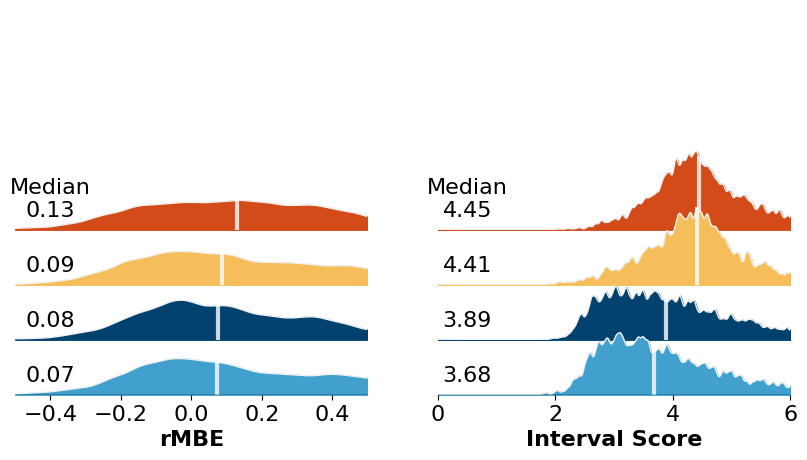

In [19]:
FONT_SIZE = 16
colors = [ '#D24B19' , '#F5BE5A', '#00416e', '#41A0CD']
HORIZON = 12
MODELS = [ 'tft_full','tft_dyn', 'nhits_full','nhits_dyn']
MODEL_LABELS = [ 'TFT','TFT (purely dynamic)', 'N-HiTS','N-HiTS (purely dynamic)']
hspace = -.75  # To reduce spacing between stacked ditsributions

# Settings presentation
fig, ax = plt.subplots(len(MODELS), 2, figsize=(10, 5), sharey=True)
text_position = [-0.4, 0.5]  
# NSE und RMSE # 
# rMBE und Interval Score; h = 1 # 0.4, 3.7 # h = 12 # -0.4, 0.3

# ('rMBE', (-0.5, 0.5)), ('Interval Score', (0., 4.))
# ('NSE', (-1,1), ('RMSE', (0., 1))
for j, (metric, _range) in enumerate([('rMBE', (-0.5, 0.5)), ('Interval Score', (0., 6))]):
    for i, model in enumerate(MODELS):
        x = metrics_subset[(metrics_subset['model_type'] == model) & (metrics_subset['horizon'] == HORIZON)][metric].values
        median = np.median(x)
        #print(f"   |{model} median = {median}")

        x_d = np.linspace(_range[0],_range[1], 2000)
        
        kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
        kde.fit(x[:, None])
        logprob = kde.score_samples(x_d[:, None])
        y_d = np.exp(logprob)

        if metric == 'NSE':
            y_d *= 2
        elif metric == 'Interval Score':
            y_d *= _range[1]
            
        if j == 0 and i == len(MODELS)-1:
            if HORIZON > 1:
                ax[i, j].set_ylabel(f'Horizon: {HORIZON} weeks', fontsize= FONT_SIZE, labelpad=30, fontweight='bold')
                ax[i, j].set_ylim(0, 10)
            else: 
                ax[i, j].set_ylabel(f'Horizon: {HORIZON} week',fontsize= FONT_SIZE, labelpad=30, fontweight='bold')
        
           
        # Plotting the distribution
        ax[i, j].plot(x_d, y_d, color="#f0f0f0", lw=1)
        ax[i, j].fill_between(x_d, y_d, alpha=1, color=colors[i])
        
        median_index = np.abs(x_d - median).argmin()
        median_y = y_d[median_index]
        ax[i, j].plot((median,median), (0,median_y), color="white", alpha = 0.8, lw=3)   
        if i == 0:
            ax[i, j].text(text_position[j], 0.4, 'Median\n{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE)
        else:
            ax[i, j].text(text_position[j], 0.4, '{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE)
      
        # Setting uniform x and y lims
        ax[i, j].set_xlim(_range)

        # Make background transparent
        rect = ax[i, j].patch
        rect.set_alpha(0)

        # Remove borders, axis ticks, and labels
        ax[i, j].set_yticks([])
        ax[i, j].grid(False)
        
        spines = ["top","right","left","bottom"]
        for s in spines:
            ax[i, j].spines[s].set_visible(False)
            
        if i == len(MODELS)-1:
            ax[i, j].xaxis.set_ticks_position('bottom')
            ax[i, j].tick_params(axis='x', labelsize=FONT_SIZE)
            #ax[i, j].spines['bottom'].set_visible(True)
            ax[i, j].axhline(y=0, color='k', linewidth = 1)
            if HORIZON == 12:
                ax[i, j].set_xlabel(metric, fontsize=FONT_SIZE,fontweight='bold')
        else:
            ax[i, j].set_xticks([])
        
        # Only for RMBE and IS
        ax[i,j].set_ylabel('')
        
plt.subplots_adjust(hspace=hspace)
# plt.subplots_adjust(hspace=hspace, top=0.8)
ylim = ax[0,0].get_ylim()

# Plot legend for horizont = 1
legend_elements = [Patch(facecolor=colors[i], edgecolor=None, label=model) for i, model in enumerate(MODEL_LABELS)]
if HORIZON == 1:
    fig.legend(handles=legend_elements, ncols=2, bbox_to_anchor=(0.1, 0.99, 0.78, 0.01), edgecolor='none', fontsize= FONT_SIZE)
# fig.savefig(os.path.join(FIGURES_PATH, f"Density_h{HORIZON}.png"), dpi=300.0)
fig.savefig(os.path.join(SHARE_PATH, 'global_mod_paper', 'figures', f'Density_h{HORIZON}_{metric}.png'), dpi=300.0)

In [ ]:
FONT_SIZE = 16
colors = [ '#D24B19' , '#F5BE5A', '#00416e', '#41A0CD']
HORIZON = 1
MODELS = [ 'tft_full_interpol', 'tft_dyn_interpol']
MODEL_LABELS = [ 'TFT without groundwater level', 'TFT without groundwater level (purely dynamic)']
hspace = -.75  # To reduce spacing between stacked ditsributions

# Settings presentation
fig, ax = plt.subplots(len(MODELS), 2, figsize=(10, 5), sharey=True)
text_position = [-0.9, 0.95]  
# NSE und RMSE # 
# rMBE und Interval Score; h = 1 # 0.4, 3.7 # h = 12 # -0.4, 0.3

# ('rMBE', (-0.5, 1)), ('Interval Score', (0., 5.)) 
for j, (metric, _range) in enumerate([('NSE', (-1,1)), ('RMSE', (0., 1))]):
    for i, model in enumerate(MODELS):
        x = metrics_subset_interpol[(metrics_subset_interpol['model_type'] == model) & 
                                    (metrics_subset_interpol['horizon'] == HORIZON)][metric].values
        median = np.median(x)
        x_d = np.linspace(_range[0],_range[1], 2000)
        
        kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
        kde.fit(x[:, None])
        logprob = kde.score_samples(x_d[:, None])
        y_d = np.exp(logprob)

        if metric == 'NSE':
            y_d *= 2
        elif metric == 'Interval Score':
            y_d *= _range[1]
            
        if j == 0 and i == len(MODELS)-1:
            if HORIZON == 1:
                ax[i, j].set_ylabel(f'Horizon: {HORIZON} week', fontsize= FONT_SIZE, labelpad=30, fontweight='bold')
                ax[i, j].set_ylim(0, 10)
            else: 
                ax[i, j].set_ylabel(f'Horizon: {HORIZON} week',fontsize= FONT_SIZE, labelpad=30, fontweight='bold')
        
        # Plotting the distribution
        ax[i,j].plot(x_d, y_d, color="#f0f0f0", lw=1)
        ax[i,j].fill_between(x_d, y_d, alpha=1, color=colors[i])
        
        median_index = np.abs(x_d - median).argmin()
        median_y = y_d[median_index]
        ax[i,j].plot((median,median), (0,median_y), color="white", alpha = 0.8, lw=3)   
        if i == 0:
             ax[i, j].text(text_position[j], 0.4, 'Median\n{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE)
        else:
             ax[i, j].text(text_position[j], 0.4, '{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE)
      
        # Setting uniform x and y lims
        ax[i,j].set_xlim(_range)

        # Make background transparent
        rect = ax[i,j].patch
        rect.set_alpha(0)

        # Remove borders, axis ticks, and labels
        ax[i,j].set_yticks([])
        ax[i,j].grid(False)
        
        spines = ["top","right","left","bottom"]
        for s in spines:
            ax[i,j].spines[s].set_visible(False)
            
        #if i == len(MODELS)-1:
        ax[i,j].xaxis.set_ticks_position('bottom')
        ax[i,j].tick_params(axis='x', labelsize=FONT_SIZE)
            #ax[i, j].spines['bottom'].set_visible(True)
        ax[i,j].axhline(y=0, color='k', linewidth = 1)
        
        if i == len(MODELS)-1:  # Only for the lowest two plots
            if HORIZON == 1:
                ax[i,j].set_xlabel(metric, fontsize=FONT_SIZE,fontweight='bold')
            else:
                ax[i,j].set_xlabel(metric, fontsize=FONT_SIZE,fontweight='bold')
        else:
            ax[i,j].set_xticks([])
        
#         if HORIZON == 1:
#             ax[i,j].set_xlabel(metric, fontsize=FONT_SIZE,fontweight='bold')
#         else:
#             ax[i,j].set_xticks([])
plt.subplots_adjust(hspace=hspace, top=1.1) # top=0.7 
ylim = ax[0,0].get_ylim()

# Plot legend for horizont = 1
legend_elements = [Patch(facecolor=colors[i], edgecolor=None, label=model) for i, model in enumerate(MODEL_LABELS)]
fig.legend(handles=legend_elements, ncols=1, bbox_to_anchor=(0.1, 0.99, 0.78, 0.01), edgecolor='none', fontsize= FONT_SIZE)
# if HORIZON == 1:
#     fig.legend(handles=legend_elements, ncols=2, bbox_to_anchor=(0.1, 0.99, 0.78, 0.01), edgecolor='none', fontsize= FONT_SIZE)
fig.savefig(os.path.join(SHARE_PATH, 
                         'global_mod_paper',
                         'figures', 
                         f'Density_tft_wo_gwl_h{HORIZON}_{metric}.png'), dpi=300.0)

#### NSE values for each intialisation

C:\Users\kunz.s\AppData\Local\Temp\7\ipykernel_13364\3866077102.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\kunz.s\AppData\Local\Temp\7\ipykernel_13364\3866077102.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\kunz.s\AppData\Local\Temp\7\ipykernel_13364\3866077102.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

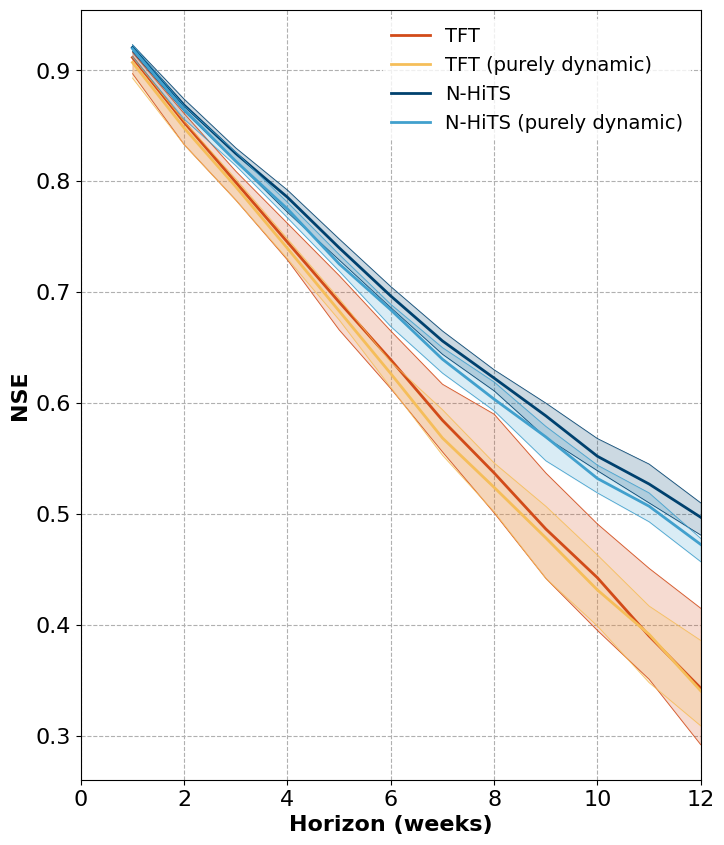

In [12]:
FONT_SIZE = 16
colors = [ '#D24B19' , '#F5BE5A', '#00416e', '#41A0CD']
MODELS = [ 'tft_full','tft_dyn', 'nhits_full','nhits_dyn', 'tft_full_interpol']
MODEL_LABELS = [ 'TFT','TFT (purely dynamic)', 'N-HiTS','N-HiTS (purely dynamic)']
METRIC = 'NSE'

################# Load metrics
# metrics = []
# for name in MODELS:
#     for root, dirs, files in os.walk(os.path.join(RESULT_PATH, 'metrics', name)):
#         count = 0
#         for file in files:
#             if file.endswith(".feather"):
#                 count += 1
#                 _df = pd.read_feather(os.path.join(root, file))
#                 _df['ini'] = count
#                 _df['model'] = name
#                 metrics.append(_df)   
# metrics_df = pd.concat(metrics).reset_index(drop=True)
##################################

# Plot 
fig, ax = plt.subplots(1, 1, figsize=(8, 10), sharey=True)

for i, model in enumerate(MODELS[:-1]):
    _df = metrics_df[(metrics_df['model_type'] == model)]
    _df.replace([np.inf, -np.inf], np.nan, inplace=True)
    stats = _df.groupby(['init', 'horizon'])[METRIC].median().reset_index()
        
    stats = stats.groupby('horizon')[METRIC].agg(['median', 'min', 'max']).reset_index()
    ax.plot(stats['horizon'],stats['median'], color=colors[i], lw=2, label = MODEL_LABELS[i])  
    ax.plot(stats['horizon'],stats['min'], color=colors[i], lw=0.5)  
    ax.plot(stats['horizon'],stats['max'], color=colors[i], lw=0.5)  
    ax.fill_between(stats['horizon'], stats['min'], stats['max'], color=colors[i], alpha=0.2)

    
# _df = metrics_full_interpol[(metrics_full_interpol['model_type'] == 'tft_full_interpol') & (metrics_full_interpol['horizon'] == 1)]
# _df.replace([np.inf, -np.inf], np.nan, inplace=True)
# _df = _df.groupby('init')[METRIC].median().reset_index()
# ax.axhline(y=_df[METRIC].median(), linestyle='--', linewidth = 2, color = 'k', label = 'TFT without groundwater level')  
    
ax.set_xlabel('Horizon (weeks)', fontsize=FONT_SIZE,fontweight='bold')
ax.set_ylabel(f"{METRIC}", fontsize=FONT_SIZE, fontweight='bold')
ax.tick_params(axis='x', labelsize=FONT_SIZE)
ax.tick_params(axis='y', labelsize=FONT_SIZE)
ax.set_xlim(0,12)
ax.legend(edgecolor='none', fontsize=FONT_SIZE-2, loc='upper right')

ax.set_axisbelow(True)
ax.grid(True, linestyle='--')

# fig.savefig(os.path.join(FIGURES_PATH, f"06_median_NSE_h1-12.png"), dpi=300.0)
# fig.savefig(os.path.join(FIGURES_PATH, f"06_median_NSE_h1-12.svg"), dpi=300.0)
fig.savefig(os.path.join(SHARE_PATH, 'global_mod_paper', 'figures', f'06_median_NSE_h1-12.png'), dpi=300.0)

### Germany map with forecast accuarcy

In [7]:
# Create geo df
coord_df = test_df_in_sample[['lon', 'lat', 'proj_id']].drop_duplicates(subset=['proj_id'])
# coord_df[~coord_df['proj_id'].isin(exclude_sites)]
gdf = gpd.GeoDataFrame(coord_df, geometry=gpd.points_from_xy(coord_df['lon'], coord_df['lat']), crs='EPSG:4326')
gdf = pd.merge(gdf, metrics_subset, on='proj_id')
# gdf.to_file(os.path.join(SHARE_PATH, 'gdf_median_nse.shp')) 

In [8]:
# Checks
print(gdf['NSE'].isna().sum())
print(gdf['NSE'].max())
print(gdf['NSE'].min())

0
0.995
-68.2695


In [15]:
# Get the number of sites with an NSE >= 0.9 after 1 week
# And an NSE >= 0.5 after 12 weeks
nse_gr09 = gdf[gdf['horizon']==1].groupby(['model_type']).apply(lambda x: x[x['NSE'] >= 0.9]).reset_index(drop=True)
nse_gr09 = pd.DataFrame(nse_gr09.groupby('model_type').size() / gdf[gdf['horizon']==1].groupby(['model_type']).size())
nse_gr09 = nse_gr09.rename(columns = {0:'ratio_above'}).reset_index()
nse_gr09['ratio_above'] = nse_gr09['ratio_above']*100
nse_gr09 = nse_gr09.round({'ratio_above':0})
nhits_full_gr09 = nse_gr09[nse_gr09['model_type']=='nhits_full']['ratio_above'][1]

nse_gr05 = gdf[gdf['horizon']==12].groupby(['model_type']).apply(lambda x: x[x['NSE'] >= 0.5]).reset_index(drop=True)
nse_gr05 = pd.DataFrame(nse_gr05.groupby('model_type').size() / gdf[gdf['horizon']==12].groupby(['model_type']).size())
nse_gr05 = nse_gr05.rename(columns = {0:'ratio_above'}).reset_index()
nse_gr05['ratio_above'] = nse_gr05['ratio_above']*100
nse_gr05 = nse_gr05.round({'ratio_above':0})
nhits_full_gr05 = nse_gr05[nse_gr05['model_type']=='nhits_full']['ratio_above'][1]

In [ ]:
# Presentation plot
unique_horizons = gdf['horizon'].unique()

# shp germany
germany_shp_df = gpd.read_file(os.path.join(DATA_PATH, 'Germany.shp'))

# Create subplots dynamically
fig, axes = plt.subplots(1, len(unique_horizons), figsize=(11 * len(unique_horizons), 10))

# Create a colorbar axis for the entire figure
cax = fig.add_axes([0.85, 0.1, 0.02, 0.8])  # Adjust the values as needed to position the colorbar vertically
norm = plt.Normalize(vmin=-1, vmax=1) #0.5

for i, horizon in enumerate(unique_horizons):
        germany_shp_df.plot(ax=axes[i], color='grey', alpha=.3, edgecolor="face", linewidth=0.4, aspect=1.5)

        # Plot points from GeoDataFrame gdf with color based on the 'NSE' column
        _gdf = gdf[(gdf['model_type']=='tft_full') & (gdf['horizon']==horizon)]
        scatter = axes[i].scatter(_gdf['geometry'].x, _gdf['geometry'].y, marker='o', s=12, 
                                  c=_gdf['NSE'], cmap='RdYlBu', 
                                  norm = norm)

        # Add axis labels and caption
        axes[i].set_xlabel('Longitude', fontweight='bold')
        axes[i].set_ylabel('Latitude', fontweight='bold')
        axes[i].set_title(f'TFT - Horizon {horizon} weeks' if horizon > 1 else f'TFT - Horizon {horizon} week', 
                          fontweight='bold', loc='center')
#         axes[0].text(0.3, 0.01,
#                      'Median NSE: 0.91',
#                      transform=axes[0].transAxes,
#                      verticalalignment='bottom',
#                      horizontalalignment='left',
#                      fontsize=FONT_SIZE-5)
#         axes[1].text(1.51, 0.01,
#                      'Median NSE: 0.50',
#                      transform=axes[0].transAxes,
#                      verticalalignment='bottom',
#                      horizontalalignment='left',
#                      fontsize=FONT_SIZE-5)

# Add a common vertical legend for the entire figure
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('NSE', fontweight='bold')

# Hide y-axis for all subplots except the first one
for ax in axes[1:]:
    ax.get_yaxis().set_visible(False)
    
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=-0.25)

plt.show()

#fig.savefig(os.path.join(FIGURES_PATH, 'nse_nhits_germany.png'))
#fig.savefig(os.path.join(FIGURES_PATH, 'nse_nhits_germany.svg'))

# For paper
fig.savefig(os.path.join(SHARE_PATH, 'global_mod_paper', 'figures', 'nse_tft_germany.png'))
fig.savefig(os.path.join(SHARE_PATH, 'global_mod_paper', 'figures', 'nse_tft_germany.svg'))

In [ ]:
# import numpy as np
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde
# import os

# unique_horizons = gdf['horizon'].unique()

# # shp germany
# germany_shp_df = gpd.read_file(os.path.join(DATA_PATH, 'Germany.shp'))

# # Create subplots dynamically
# fig, axes = plt.subplots(1, len(unique_horizons), figsize=(11 * len(unique_horizons), 10))

# # Create a colorbar axis for the entire figure
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust the values as needed to position the colorbar vertically
# norm = plt.Normalize(vmin=-0.5, vmax=1)

# for i, horizon in enumerate(unique_horizons):
#     germany_shp_df.plot(ax=axes[i], color='grey', alpha=.3, edgecolor="face", linewidth=0.4, aspect=1.5)

#     # Plot points from GeoDataFrame gdf with color based on the 'NSE' column
#     _gdf = gdf[(gdf['model_type']=='nhits_full') & (gdf['horizon']==horizon)]
#     scatter = axes[i].scatter(_gdf['geometry'].x, _gdf['geometry'].y, marker='o', s=12, 
#                               c=_gdf['NSE'], cmap='RdYlBu', 
#                               norm=norm)

#     # Perform KDE on NSE values
#     nse_values = _gdf['NSE']
#     kde = gaussian_kde(nse_values)
#     x_vals = np.linspace(nse_values.min(), nse_values.max(), 100)
#     y_vals = kde(x_vals)
#     axes[i].plot(x_vals, y_vals, color='purple')

#     # Add axis labels and caption
#     axes[i].set_xlabel('Longitude', fontweight='bold')
#     axes[i].set_ylabel('Latitude', fontweight='bold')
#     axes[i].set_title(f'N-HiTS {horizon} weeks' if horizon > 1 else f'N-HiTS {horizon} week', 
#                       fontweight='bold', loc='center')

# # Add a common vertical legend for the entire figure
# cbar = plt.colorbar(scatter, cax=cax)
# cbar.set_label('NSE', fontweight='bold')

# # Hide y-axis for all subplots except the first one
# for ax in axes[1:]:
#     ax.get_yaxis().set_visible(False)
    
# plt.show()

### Examples groundwaterlevel predictions

In [5]:
forecasts = []

# nhits_full
_df = pd.read_feather(os.path.join(RESULT_PATH,
                                   'predictions',
                                   'nhits',
                                   'nhits_full',
                                   'nhits_full_1024_10_Epochs',
                                   'in_sample_quantiles_nhits_version_1_predictions.feather'))
_df['model'] = 'nhits_full'
forecasts.append(_df)

# tft_full
_df = pd.read_feather(os.path.join(RESULT_PATH,
                                   'predictions',
                                   'tft',
                                   'tft_full',
                                   'tft_full_4096_10_Epochs',
                                   'in_sample_quantiles_tft_version_2_predictions.feather'))
_df['model'] = 'tft_full'
forecasts.append(_df)
forecasts_df = pd.concat(forecasts, sort=True).reset_index(drop=True)

In [17]:
# Select top 10 performing sites (according to NSE)
ten_best = metrics_subset[(metrics_subset['model_type'] == 'nhits_full') & (metrics_subset['horizon'] == 12)].sort_values(by='NSE', ascending=False).head(10)

# Select ten mediocre sites
ten_mediocre = metrics_subset[(metrics_subset['model_type'] == 'nhits_full') & 
               (metrics_subset['horizon'] == 12) & 
               (metrics_subset['NSE'] >= 0.49) &
               (metrics_subset['NSE'] <= 0.51)].sample(n=10, random_state=42)

# Select ten bad performing sites
ten_bad = metrics_subset[(metrics_subset['model_type'] == 'nhits_full') & 
               (metrics_subset['horizon'] == 12) & 
               (metrics_subset['NSE'] <= -0.99) & 
               (metrics_subset['NSE'] >= -1.1)].sample(n=10, random_state=42)

ten_best['eval'] = "best"
ten_mediocre['eval'] = "mediocre"
ten_bad['eval'] = "bad"

example_ts = pd.concat((ten_best, ten_mediocre, ten_bad))
example_ts = example_ts.merge(metrics_subset[(metrics_subset['proj_id'].isin(example_ts['proj_id'])) &
              (metrics_subset['horizon']==12) & 
              (metrics_subset['model_type']=='tft_full')][['proj_id', 'NSE']], on='proj_id', 
                suffixes=('_N-HiTS', '_TFT'))

# pq.write_table(pa.Table.from_pandas(example_ts), os.path.join(RESULT_PATH, 'example_ts.parquet'))

In [99]:
# Selection of bad and good performing wells
bad_performing = list(metrics_subset[(metrics_subset['horizon']==12) & (metrics_subset['NSE']<= -1)]['proj_id'])
good_performing = list(metrics_subset[(metrics_subset['horizon']==12) & (metrics_subset['NSE']>= 0.85)]['proj_id'])
ten_best = list(ten_best['proj_id'])

a 0 1
a 1 12


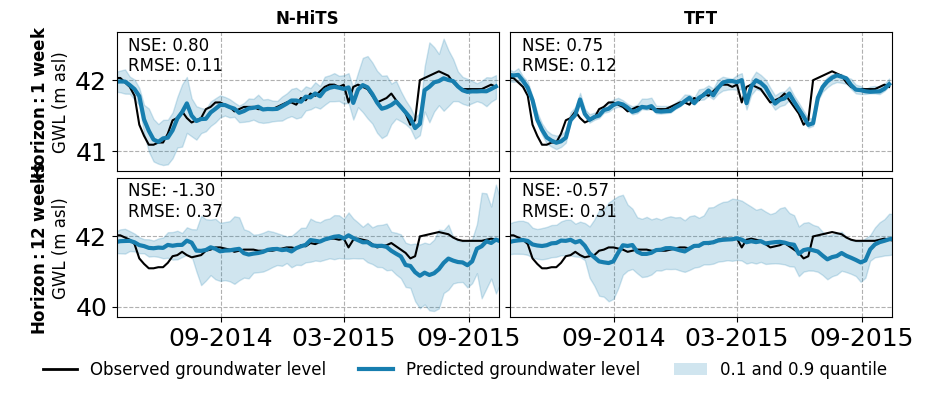

In [222]:
# Visualise predictions
# Use this for individual wells 
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates

MODEL_MAP = {
    'nhits_full': 'N-HiTS',
    'tft_full': 'TFT',}

PROJ_IDS = ['BB_30429065']
#'ST_42420008', 'ST_42420008', 'ST_42410003', 'HE_10108', 'BY_27116', 
# 'BW_103-763-0', 'BY_4172', 'BY_27116', 'NI_9700251'
subfigures = 'abc'
ys = [.35, .37, .5]
heights = [5, 6., 6.]
FONT_SIZE = 12

for proj_id, sub, y_, height in zip(PROJ_IDS, subfigures, ys, heights):
    fig, ax = plt.subplots(2, 2, figsize=(10, height), sharex='all', sharey='row')

    for c, horizon in enumerate([1, 12]):
        forecasts = forecasts_df[(forecasts_df['proj_id'] == proj_id) & (forecasts_df['horizon'] == horizon)]
        metrics = metrics_subset[(metrics_subset['proj_id'] == proj_id) & (metrics_subset['horizon'] == horizon)]
        print(sub, c, horizon)
        for idx, (model, sub_group) in enumerate(forecasts.groupby('model')):
            _df = sub_group.sort_values(by='time').dropna(subset=['time']).reset_index(drop=True)
            ax[c][idx].plot(_df['time'], _df['gwl'], color ='k')
            ax[c][idx].plot(_df['time'], _df['forecast'], color ='#177eaf', lw = 3)

            ax[c][idx].fill_between(_df['time'], _df['forecast_q10'], _df['forecast_q90'], color='#177eaf', alpha=.20)
   
            _m = metrics[metrics['model_type'] == model].iloc[0]
            ax[c][idx].text(0.03, 0.97,f"NSE: {_m['NSE']:.2f}\nRMSE: {_m['RMSE']:.2f}",
                transform=ax[c][idx].transAxes, verticalalignment='top', horizontalalignment='left',fontsize=FONT_SIZE)
            
            if horizon > 1 :
                ax[c][0].set_ylabel(f'\n' + r'$\bf{Horizon: ' + f'{horizon}' + '\ weeks}$\nGWL (m asl)', fontsize=FONT_SIZE)
            else:
                ax[c][0].set_ylabel(f'\n' + r'$\bf{Horizon: ' + f'{horizon}' + '\ week }$\nGWL (m asl)', fontsize=FONT_SIZE)

            if sub != 'a':
                ax[c][idx].xaxis.set_tick_params(labelbottom=False)
                ax[c][idx].xaxis.set_tick_params(which='minor', labelbottom=False)
                ax[c][idx].set_xlabel(None)
            if c == 0: 
                ax[c][idx].set_title(f'{MODEL_MAP[model]}', loc='center', fontsize=FONT_SIZE ,fontweight='bold')
                
            #ax[c][idx].set_ylim(201.5,205)   
            ax[c][idx].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            
            ax[c][idx].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax[c][idx].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
            ax[c][idx].set_xlim(pd.Timestamp(2014, 4, 1), pd.Timestamp(2015, 10, 15))
            ax[c][idx].set_axisbelow(True)
            ax[c][idx].grid(True, linestyle='--')

    fig.align_labels()
    #fig.subplots_adjust(hspace=0.05, wspace=0.03)#, top=0.72, bottom=0.15
    #plt.annotate(f"({sub})\nwell id: {proj_id}", (0.015, y_), xycoords='figure fraction', rotation=90, va='center', ha='center', weight='bold')
#     if sub == 'a':
#         legend_elements = [
#             Line2D([0], [0], color='k', lw=2, label='Observed groundwater level'),
#             Line2D([0], [0], color='#177eaf',  lw=3, label='Predicted groundwater level'),
#             Patch(facecolor='#177eaf', alpha=0.2, edgecolor=None, label='0.1 and 0.9 quantile'),
#         ]
#         fig.legend(handles=legend_elements,  ncols=3, edgecolor='none', fontsize = FONT_SIZE, loc= 'lower center')

#fig.savefig(os.path.join(FIGURES_PATH, '06_Example_TimeSeries.png'))
fig.savefig(os.path.join(SHARE_PATH,'global_mod_paper', 'figures', 'wells_bad_performance', f'{proj_id}_example.png'))

#### Example wells with flashy hydrograph and with distorted seasonality

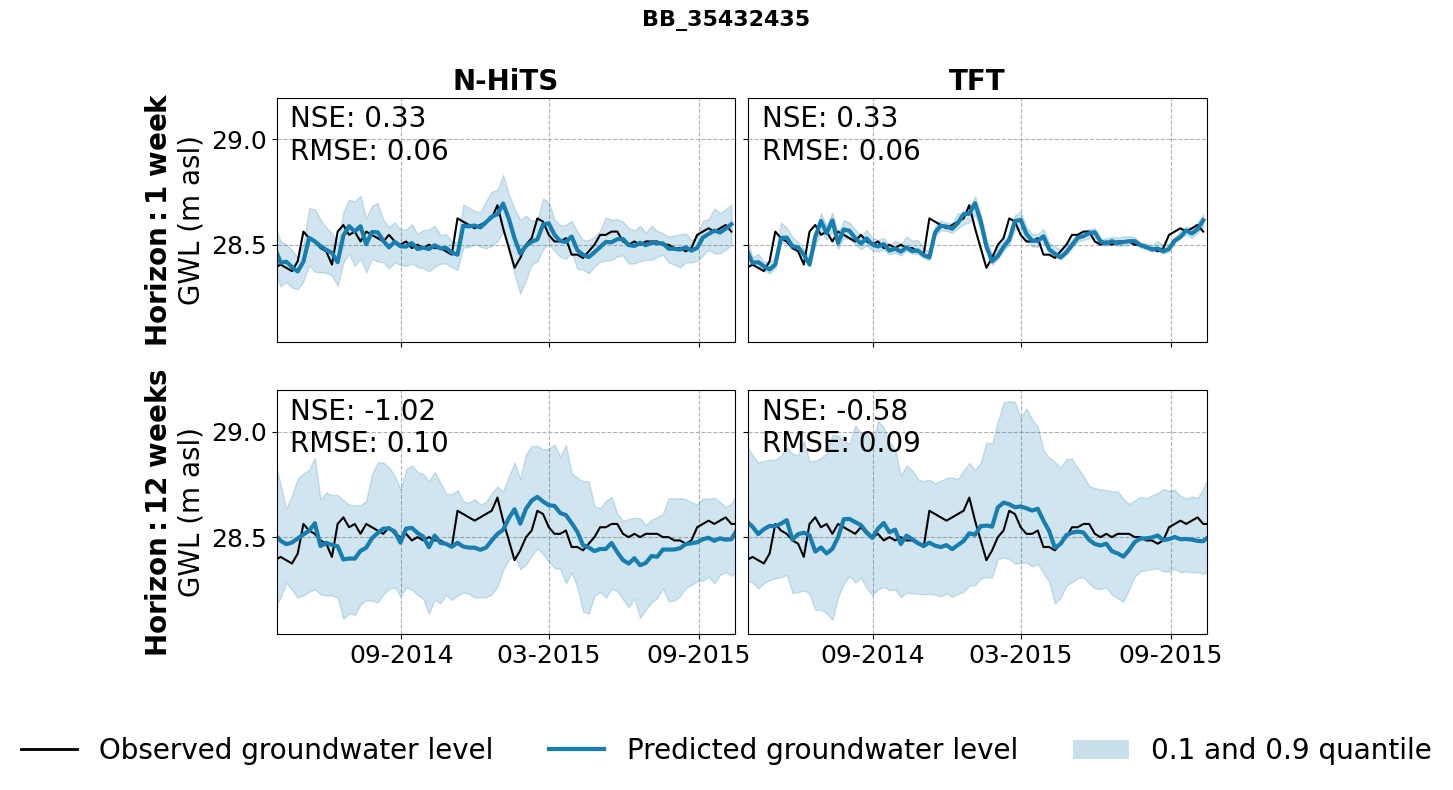

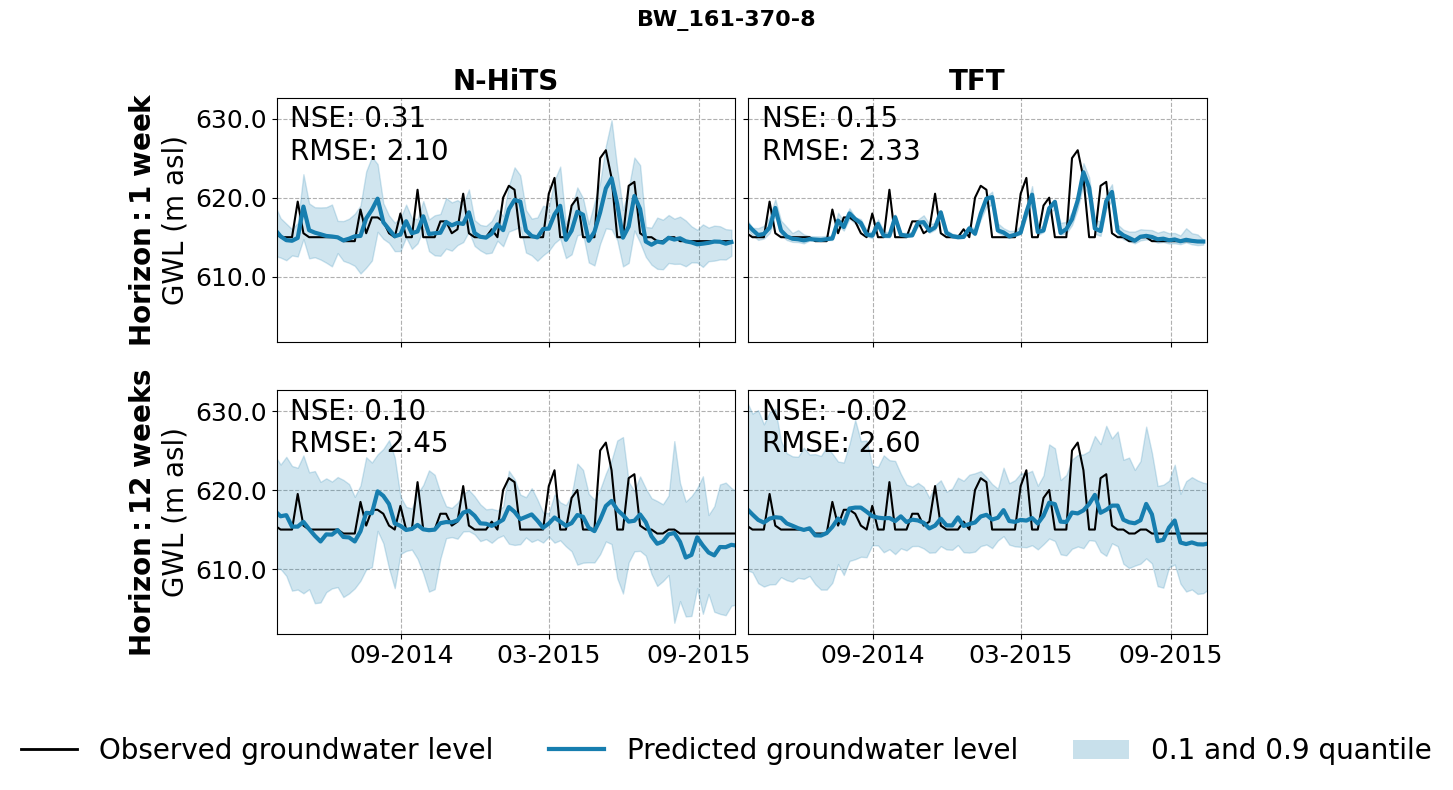

In [95]:
# Loop version for multiple plots
# bad_performing
# good_performing
# ten_best
# ten_bad 
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates

MODEL_MAP = {
    'nhits_full': 'N-HiTS',
    'tft_full': 'TFT',}

# Distorted expected seasonality: BW_118-068-1, BB\_35432435
# Flashy GWM well BW_161-370-8

for proj_id in ['BB_35432435', 'BW_161-370-8']:
    fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex='all', sharey='all')
    fig.suptitle(proj_id, fontsize=16, fontweight='bold')  # Adding title to the whole figure

    for c, horizon in enumerate([1, 12]):
            forecasts = forecasts_df[(forecasts_df['proj_id'] == proj_id) & (forecasts_df['horizon'] == horizon)]
            metrics = metrics_subset[(metrics_subset['proj_id'] == proj_id) & (metrics_subset['horizon'] == horizon)]
          #  print(sub, c, horizon)
            for idx, (model, sub_group) in enumerate(forecasts.groupby('model')):
                _df = sub_group.sort_values(by='time').dropna(subset=['time']).reset_index(drop=True)
                ax[c][idx].plot(_df['time'], _df['gwl'], color ='k')
                ax[c][idx].plot(_df['time'], _df['forecast'], color ='#177eaf', lw = 3)

                ax[c][idx].fill_between(_df['time'], _df['forecast_q10'], _df['forecast_q90'], color='#177eaf', alpha=.20)

                _m = metrics[metrics['model_type'] == model].iloc[0]
                ax[c][idx].text(0.03, 0.97,f"NSE: {_m['NSE']:.2f}\nRMSE: {_m['RMSE']:.2f}",
                    transform=ax[c][idx].transAxes, verticalalignment='top', horizontalalignment='left',fontsize=FONT_SIZE)

                if horizon > 1 :
                    ax[c][0].set_ylabel(f'\n' + r'$\bf{Horizon: ' + f'{horizon}' + '\ weeks}$\nGWL (m asl)', fontsize=FONT_SIZE)
                else:
                    ax[c][0].set_ylabel(f'\n' + r'$\bf{Horizon: ' + f'{horizon}' + '\ week }$\nGWL (m asl)', fontsize=FONT_SIZE)

                if c == 1:
                    ax[c][idx].xaxis.set_tick_params(labelbottom=True)
                    # ax[c][idx].xaxis.set_tick_params(which='minor', labelbottom=True)
                    ax[c][idx].set_xlabel(None)
                if c == 0: 
                    ax[c][idx].set_title(f'{MODEL_MAP[model]}', loc='center', fontsize=FONT_SIZE ,fontweight='bold')

                    #ax[c][idx].set_ylim(201.5,205)   
                ax[c][idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

                ax[c][idx].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
                ax[c][idx].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
                ax[c][idx].set_xlim(pd.Timestamp(2014, 4, 1), pd.Timestamp(2015, 10, 15))
                ax[c][idx].set_axisbelow(True)
                ax[c][idx].grid(True, linestyle='--')

            #fig.align_labels()
            fig.subplots_adjust(hspace=0.2, wspace=0.03, top=0.87, bottom=0.2)
            legend_elements = [
                Line2D([0], [0], color='k', lw=2, label='Observed groundwater level'),
                Line2D([0], [0], color='#177eaf',  lw=3, label='Predicted groundwater level'),
                Patch(facecolor='#177eaf', alpha=0.2, edgecolor=None, label='0.1 and 0.9 quantile'),
                ]
            fig.legend(handles=legend_elements,  ncols=3, edgecolor='none', fontsize = FONT_SIZE, loc= 'lower center')
        
            fig.savefig(os.path.join(SHARE_PATH,'global_mod_paper', 'figures', 'wells_paper', f'{proj_id}.png'))

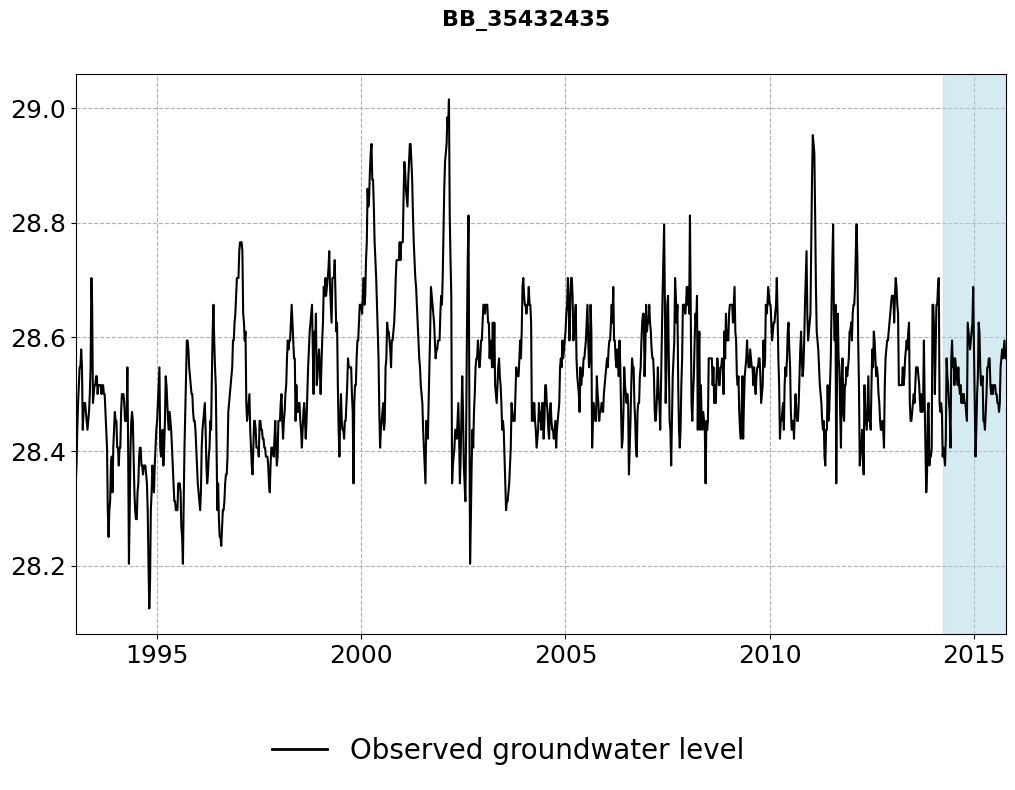

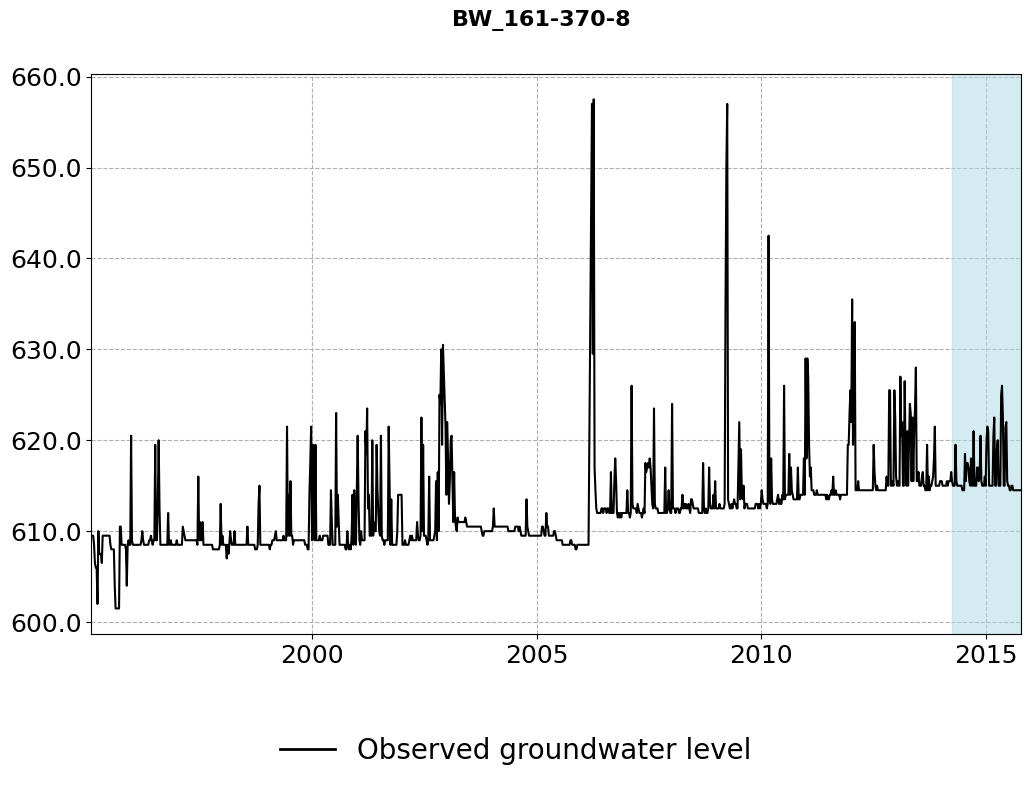

In [110]:
# Plot for the complete time series
compl_df = pd.concat([train_df[['proj_id', 'time', 'time_idx', 'gwl']], 
                      val_df[['proj_id', 'time', 'time_idx', 'gwl']], 
                      test_df_in_sample[['proj_id', 'time', 'time_idx', 'gwl']]
                      ]
                     )
compl_df = compl_df.sort_values(by=['proj_id', 'time'])

for proj_id in ['BB_35432435', 'BW_161-370-8']:
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex='all', sharey='all')
    fig.suptitle(proj_id, fontsize=16, fontweight='bold')  # Adding title to the whole figure

    _df = compl_df[(compl_df['proj_id'] == proj_id)]
    _df = _df.sort_values(by='time').dropna(subset=['time']).reset_index(drop=True)
    min_date = _df['time'].min()

    ax.plot(_df['time'], _df['gwl'], color ='k')
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlim(min_date, pd.Timestamp(2015, 10, 15))
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--')
    
    # overlay
    ax.axvspan(pd.Timestamp(2014, 4, 1), pd.Timestamp(2015, 10, 15), color='lightblue', alpha=0.5)

    #fig.align_labels()
    fig.subplots_adjust(hspace=0.1, wspace=0.03, top=0.9, bottom=0.2)
    legend_elements = [
                Line2D([0], [0], color='k', lw=2, label='Observed groundwater level')
                ]
    fig.legend(handles=legend_elements,  ncols=3, edgecolor='none', fontsize = FONT_SIZE, loc= 'lower center')
    
    fig.savefig(os.path.join(SHARE_PATH,'global_mod_paper', 'figures', 'wells_paper', f'{proj_id}_complete.png'))

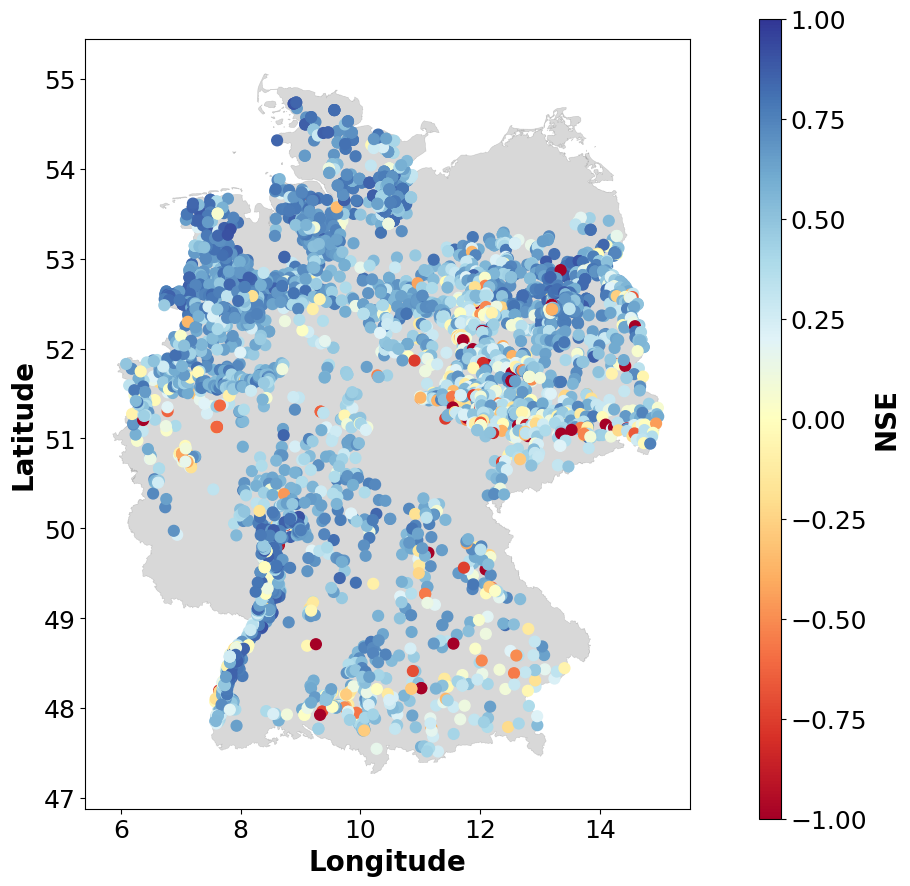

In [151]:
# Map plot

# shp germany
germany_shp_df = gpd.read_file(os.path.join(DATA_PATH, 'Germany.shp'))
#hyraum_shp = gpd.read_file(os.path.join(DATA_PATH, 'hyraum_v32', 'hyraum_gr__v32_poly.shp'))
# hyraum_shp = hyraum_shp.to_crs('EPSG:4326')

# Create subplots dynamically
fig, axes = plt.subplots(1, figsize=(11, 10))

# Create a colorbar axis for the entire figure
cax = fig.add_axes([0.85, 0.1, 0.02, 0.8])  # Adjust the values as needed to position the colorbar vertically
norm = plt.Normalize(vmin=-1, vmax=1) #0.5

germany_shp_df.plot(ax=axes, color='grey', alpha=.3, edgecolor="face", linewidth=0.4, aspect=1.5)
# hyraum_shp.plot(ax=axes, color='black', alpha=.3, edgecolor="face", linewidth=1.5, aspect=1.5)

_gdf = gdf[(gdf['model_type']=='nhits_full') & 
                   (gdf['horizon']==12) & 
                    gdf['proj_id'].isin(['BB_35432435', 'BW_161-370-8'])]
scatter = axes.scatter(_gdf['geometry'].x, 
                          _gdf['geometry'].y,
                          marker='o',
                          s=60, 
                          c=_gdf['NSE'],
                          cmap='RdYlBu', 
                          norm = norm)

# Add axis labels and caption
axes.set_xlabel('Longitude', fontweight='bold')
axes.set_ylabel('Latitude', fontweight='bold')

# Add a common vertical legend for the entire figure
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('NSE', fontweight='bold')

plt.subplots_adjust(wspace=-0.25)

plt.show()
# fig.savefig(os.path.join(SHARE_PATH,'global_mod_paper', 'figures', 'wells_paper', f'wells_location.png'))

## Kernel density estimation

In [157]:
# Reproject coordinates to a projected CRS in order to properly calculate distances
gdf_subset = gdf[(gdf['model_type']=='nhits_full') & (gdf['horizon']==12)]
target_crs = 'EPSG:25832'
gdf_subset = gdf_subset.to_crs(target_crs)

hyraum_shp = gpd.read_file(os.path.join(DATA_PATH, 'hyraum_v32', 'hyraum_gr__v32_poly.shp'))
hyraum_shp = hyraum_shp.to_crs(target_crs)

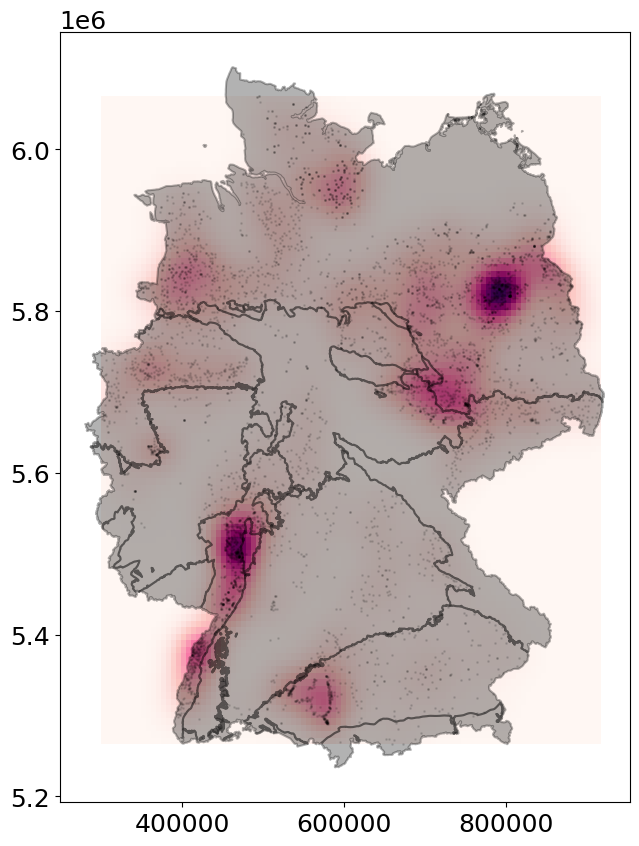

In [158]:
# Get X and Y coordinates of well points
x_sk = gdf_subset["geometry"].x
y_sk = gdf_subset["geometry"].y

# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = gdf_subset.total_bounds

# Create a cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:100j, min_y_sk:max_y_sk:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()]).T

# Create 2-D array of the coordinate values of the well points
coord_combined = np.vstack([x_sk, y_sk]).T

# Get kernel density estimator (can change parameters as desired)
kde_sk = KernelDensity(bandwidth = 20000, 
                       metric = 'euclidean',
                       kernel = 'gaussian',
                       algorithm = 'auto')

# Fit kernel density estimator to well coordinates
kde_sk.fit(coord_combined)

# Evaluate the estimator on coordinate pairs
Z_sk = np.exp(kde_sk.score_samples(positions_sk))

# Reshape the data to fit mesh grid
Z_sk_reshap = Z_sk.reshape(XX_sk.shape)

fig, ax = plt.subplots(1, 1, figsize = (11, 10))

# germany_shp_df.plot(ax=ax, color='grey', alpha=.1, edgecolor="face", linewidth=0.4, aspect=1.5)
ax.imshow(np.rot90(Z_sk_reshap), cmap = "RdPu", extent = [min_x_sk, max_x_sk, min_y_sk, max_y_sk])
hyraum_shp.plot(ax=ax, color='black', alpha=.3, edgecolor="face", linewidth=1.5)
ax.plot(x_sk, y_sk, 'k.', markersize = 2, alpha = 0.1)
plt.show()
# fig.savefig(os.path.join(FIGURES_PATH, 'data_density_hydroraum.png'))

In [159]:
# Data densitiy vs NSE
density_data = pd.DataFrame({
    'lon': positions_sk[:, 0].flatten(),
    'lat': positions_sk[:, 1].flatten(),
    'KDE_Value': Z_sk
})
density_data = gpd.GeoDataFrame(density_data, geometry=gpd.points_from_xy(density_data['lon'], density_data['lat']), crs='EPSG:25832')

In [160]:
density_data['KDE_Value'].describe()
# fig, ax = plt.subplots(1, 1, figsize = (11, 10))

# # density_data_subset = density_data[density_data['KDE_Value'] > 6.750455e-12]
# density_data[density_data['KDE_Value'] > 6.750455e-12].plot(ax=ax, 
#                                                             color='grey',
#                                                             alpha=.3,
#                                                             edgecolor="face", linewidth=0.4)
# hyraum_shp.plot(ax=ax, color='black', alpha=.3, edgecolor="face", linewidth=1.5)
# # ax.contour(XX_sk, YY_sk, Z_sk_reshap, levels=[6.750455e-12], colors='red', linewidths=2)

count    1.000000e+04
mean     1.968992e-12
std      2.528412e-12
min      1.871051e-26
25%      1.404320e-13
50%      1.043733e-12
75%      2.755446e-12
max      1.992239e-11
Name: KDE_Value, dtype: float64

In [161]:
density_data = density_data.sjoin_nearest(gdf_subset[['proj_id', 'NSE', 'horizon', 'model_type', 'geometry']], how='right')

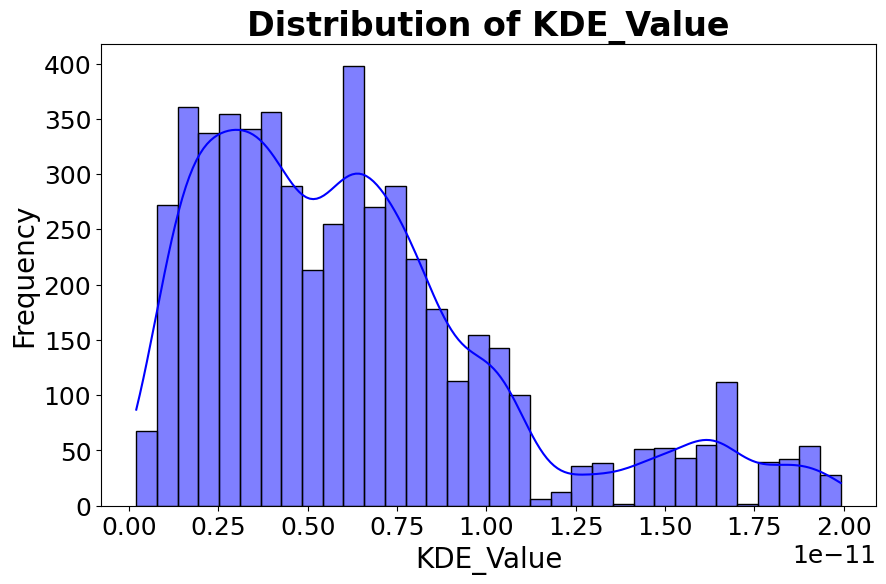

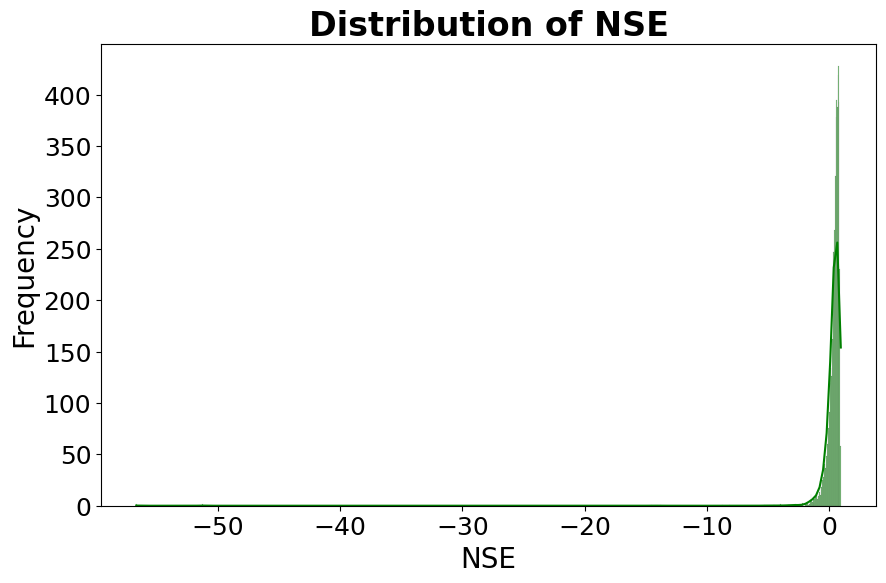

In [162]:
# Plotting KDE_Value distribution
plt.figure(figsize=(10, 6))
sns.histplot(density_data['KDE_Value'], kde=True, color='blue')
plt.title('Distribution of KDE_Value')
plt.xlabel('KDE_Value')
plt.ylabel('Frequency')
plt.show()

# Plotting NSE distribution
plt.figure(figsize=(10, 6))
sns.histplot(density_data['NSE'], kde=True, color='green')
plt.title('Distribution of NSE')
plt.xlabel('NSE')
plt.ylabel('Frequency')
plt.show()

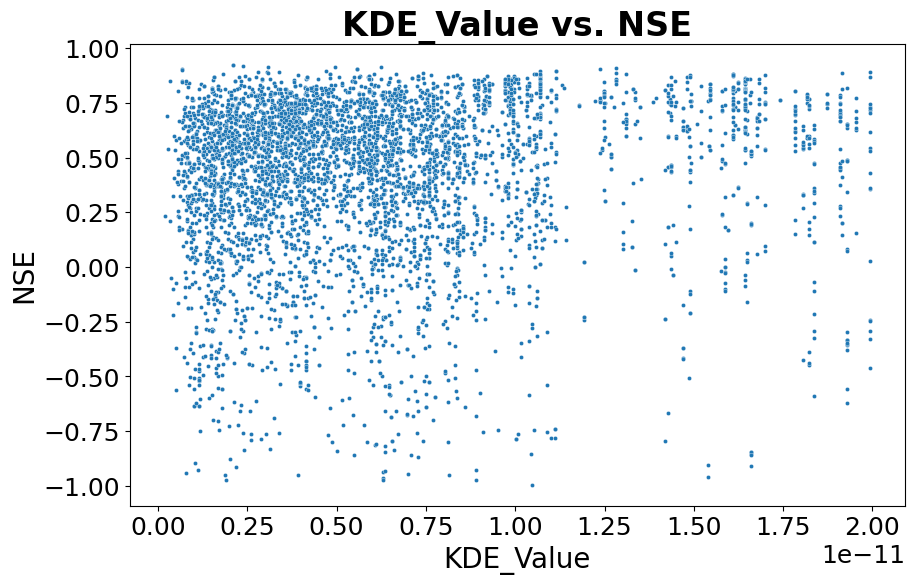

In [24]:
# Plot KDE_Value against NSE
plt.figure(figsize=(10, 6))
sns.scatterplot(x='KDE_Value', y='NSE', data=density_data[density_data['NSE'] > -1])
plt.title('KDE_Value vs. NSE')
plt.xlabel('KDE_Value')
plt.ylabel('NSE')
plt.show()

In [25]:
# Correlation coef (pearson and spearmann)
# Calculate Pearson correlation
print(density_data['KDE_Value'].corr(density_data['NSE'], method='pearson'))

# Calculate Spearman correlation
print(density_data['KDE_Value'].corr(density_data['NSE'], method='spearman'))

0.020332462146349813
0.12125529667848525


In [ ]:
# Remove outliers (pearson is sensitive to outliers)
density_data_rm_outier = density_data[density_data['NSE'] > -1]
print(density_data_rm_outier['KDE_Value'].corr(density_data_rm_outier['NSE'], method='pearson'))
print(density_data_rm_outier['KDE_Value'].corr(density_data_rm_outier['NSE'], method='spearman'))

### Delineate high data density areas

In [163]:
# Delineate polygons for high density data areas
from shapely.geometry import Polygon

contour = ax.contour(XX_sk, YY_sk, Z_sk_reshap, levels=[6.750455e-12], colors='red', linewidths=2)
# Extract the polygons from the contour plot
high_density_polygons = [contour.collections[0].get_paths()[i].vertices for i in range(len(contour.collections[0].get_paths()))]
# high_density_geo = [gpd.GeoSeries([Point(x, y) for x, y in poly]) for poly in high_density_polygons]
high_density_geo = [Polygon(poly) for poly in high_density_polygons]
high_density_geo = gpd.GeoDataFrame(geometry=high_density_geo, crs=target_crs)
high_density_geo = high_density_geo.reset_index()

high_density_gdf = high_density_geo.sjoin(gdf_subset[['proj_id', 'NSE', 'horizon', 'model_type', 'geometry']], how='inner')
# high_density_gdf = high_density_gdf.reset_index()

nse_high_density = pd.DataFrame(high_density_gdf.groupby(['index'])['NSE'].median()).reset_index().merge(
                   pd.DataFrame(high_density_gdf.groupby(['index'])['NSE'].size()).reset_index().rename(columns={'NSE':'N'}),
                   on='index')
high_density_geo = high_density_geo.merge(nse_high_density, on='index')

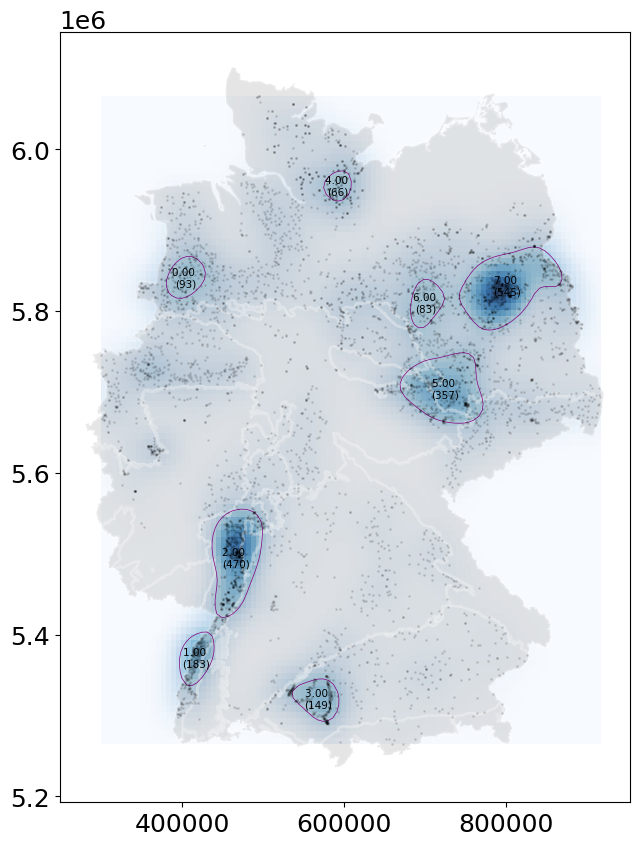

In [14]:
# Plot the map with high-density areas and NSE values
fig, ax = plt.subplots(figsize=(11, 10))
ax.imshow(np.rot90(Z_sk_reshap), cmap="Blues", extent=[min_x_sk, max_x_sk, min_y_sk, max_y_sk], alpha=.9)
hyraum_shp.plot(ax=ax, color='grey', alpha=.2, edgecolor="white", linewidth=2)
ax.plot(x_sk, y_sk, 'k.', markersize=2, alpha=0.1)
high_density_geo.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=0.5)

for idx, row in high_density_geo.iterrows():
    centroid_x = row['geometry'].centroid.x
    centroid_y = row['geometry'].centroid.y
    ax.annotate(text=f"{row['index']:.2f} \n({row['N']})",
                xy=(centroid_x, centroid_y), 
                color='black',
                fontsize=7.5,
                ha='center',
                va='center')
plt.show()
# fig.savefig(os.path.join(FIGURES_PATH, 'data_density_nse_labelled.png'))
# fig.savefig(os.path.join(FIGURES_PATH, 'data_density_nse_labelled.svg'))

### Bad predictions in some high data density areas

In [18]:
critical_ids = high_density_gdf[(high_density_gdf['NSE']<0)]['proj_id'].unique()
critical_ids_bw = [x for x in critical_ids if re.match('BW', x)]

critical_ids_bw = high_density_gdf[(high_density_gdf['index']==3)]['proj_id']
critical_ids_bw

critical_ids_st = high_density_gdf[(high_density_gdf['index']==6)]['proj_id']

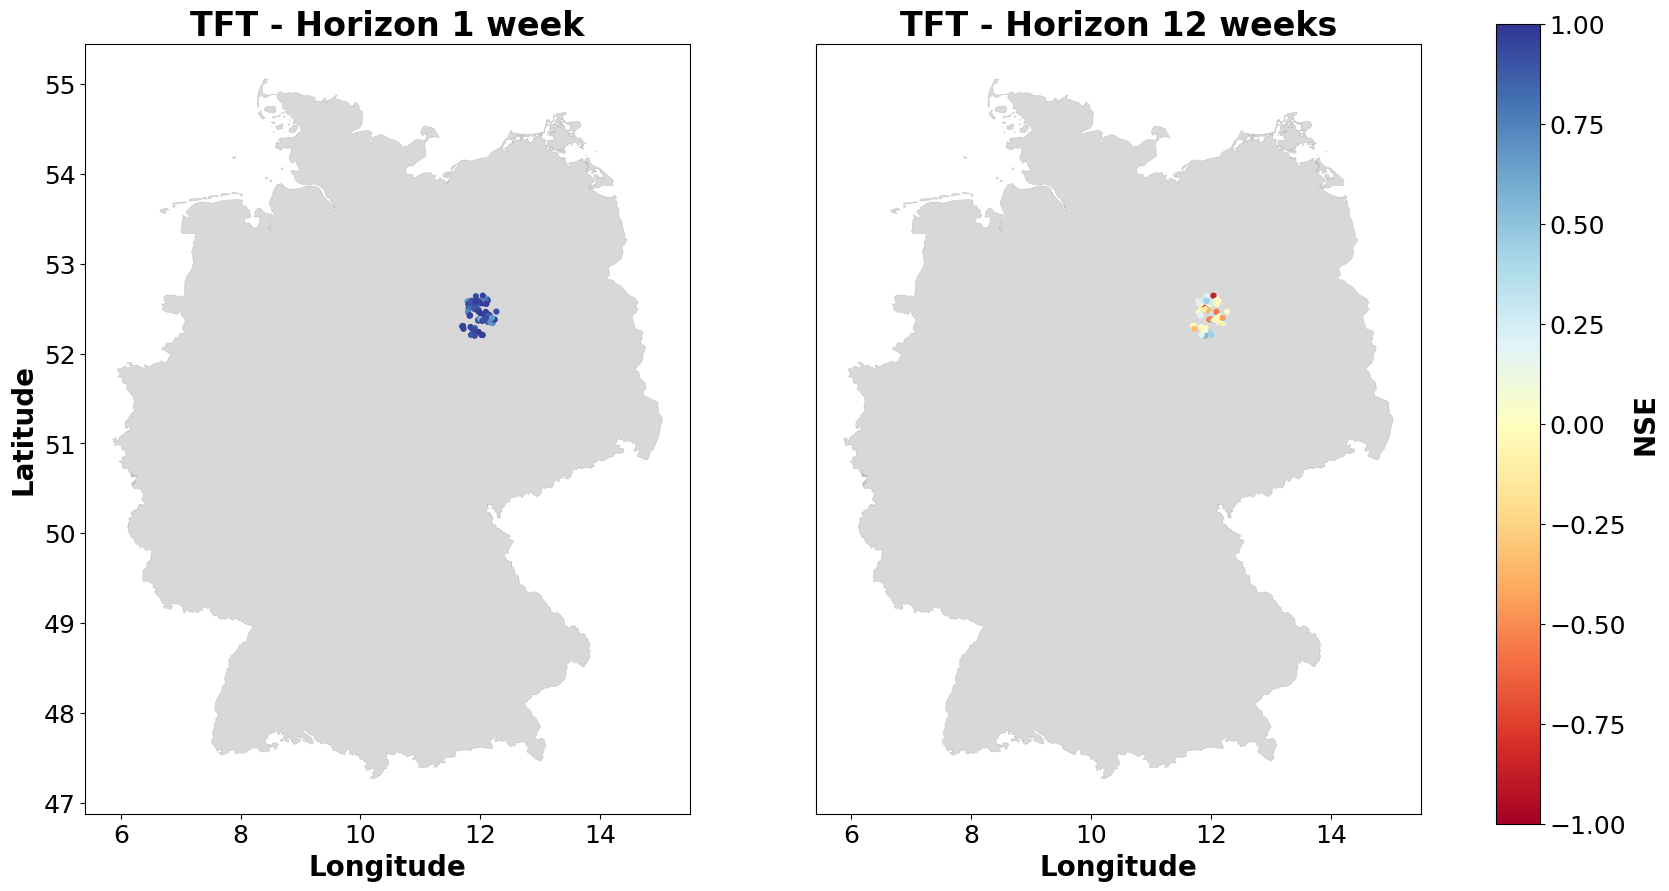

In [47]:
unique_horizons = gdf['horizon'].unique()

# shp germany
germany_shp_df = gpd.read_file(os.path.join(DATA_PATH, 'Germany.shp'))

# Create subplots dynamically
fig, axes = plt.subplots(1, len(unique_horizons), figsize=(11 * len(unique_horizons), 10))

# Create a colorbar axis for the entire figure
cax = fig.add_axes([0.85, 0.1, 0.02, 0.8])  # Adjust the values as needed to position the colorbar vertically
norm = plt.Normalize(vmin=-1, vmax=1) #0.5

for i, horizon in enumerate(unique_horizons):
        germany_shp_df.plot(ax=axes[i], color='grey', alpha=.3, edgecolor="face", linewidth=0.4, aspect=1.5)

        # Plot points from GeoDataFrame gdf with color based on the 'NSE' column       
        _gdf = gdf[(gdf['model_type']=='tft_full') & 
                   (gdf['horizon']==horizon) & 
                    gdf['proj_id'].isin(critical_ids_st)]
        scatter = axes[i].scatter(_gdf['geometry'].x, _gdf['geometry'].y, marker='o', s=12, 
                                  c=_gdf['NSE'], cmap='RdYlBu', 
                                  norm = norm)

        # Add axis labels and caption
        axes[i].set_xlabel('Longitude', fontweight='bold')
        axes[i].set_ylabel('Latitude', fontweight='bold')
        axes[i].set_title(f'TFT - Horizon {horizon} weeks' if horizon > 1 else f'TFT - Horizon {horizon} week', 
                          fontweight='bold', loc='center')

# Add a common vertical legend for the entire figure
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('NSE', fontweight='bold')

# Hide y-axis for all subplots except the first one
for ax in axes[1:]:
    ax.get_yaxis().set_visible(False)
    
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=-0.25)

plt.show()

### Interactive map

In [65]:
import folium
import branca.colormap as cm

# prepare geo df
_gdf = gdf[(gdf['model_type']=='nhits_full') & 
                        (gdf['horizon']==12) & 
                        gdf['proj_id'].isin(critical_ids_st)]
_gdf_coord = [[point.xy[1][0], point.xy[0][0]] for point in _gdf.geometry]
_gdf_coord

# Create a continuous color scale using the RdYlBu colormap
colormap = cm.linear.RdYlBu_11.scale(-2, _gdf.NSE.max())
colormap

m = folium.Map(location=[52.126162, 11.640616], zoom_start=10, tiles='CartoDB Positron', control_scale=True)

# Write a loop to add points one by one to the map
for coordinates, NSE_val in zip(_gdf_coord, _gdf.NSE) :
    m.add_child(folium.CircleMarker(
        location=coordinates,
        popup=NSE_val,
        radius=8,  # Adjust the radius as needed
        color=colormap(NSE_val),
        fill=True,
        fill_color=colormap(NSE_val),
        fill_opacity=1.5
    ))
    
colormap.add_to(m)

# Save the map as an HTML file
m.save(os.path.join(SHARE_PATH, 'global_mod_paper', 'gis', 'map_wells_magdeburg_stendal.html'))

m

#### XXX

In [62]:
# Why are the predictions bad in some of the high data density areas?
critical_forecast = forecasts_df[(forecasts_df['model']=='nhits_full')&
                                 (forecasts_df['horizon']==12)]

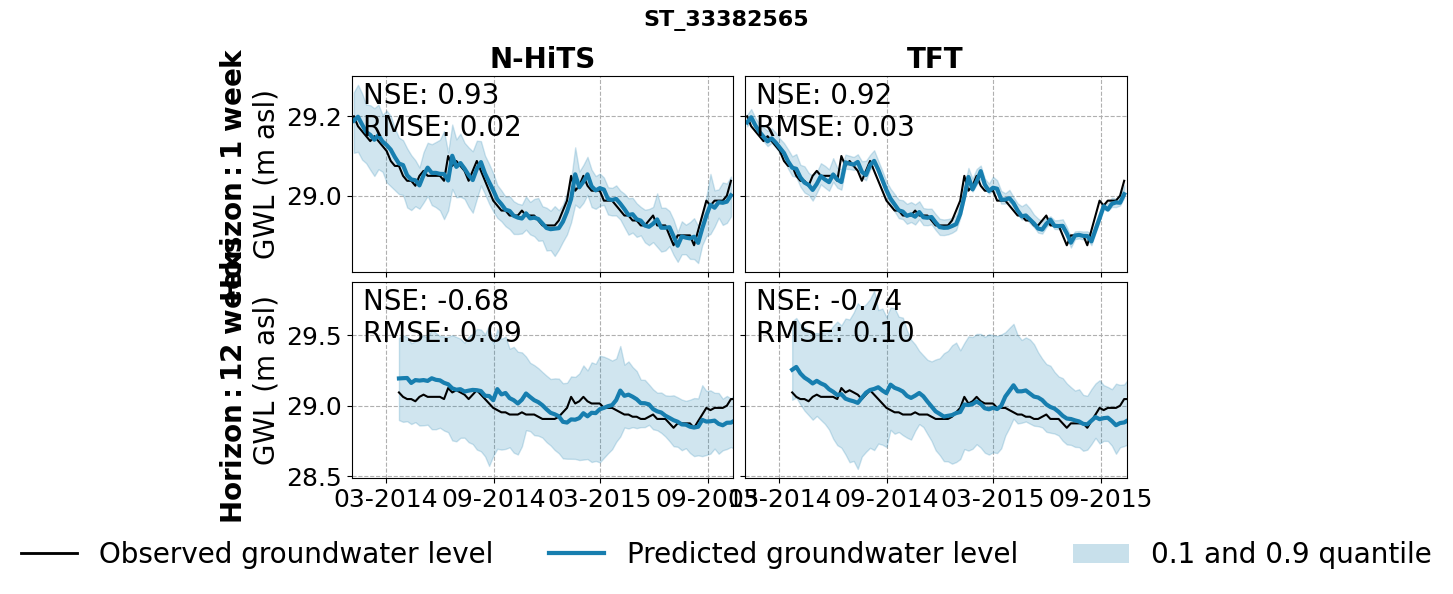

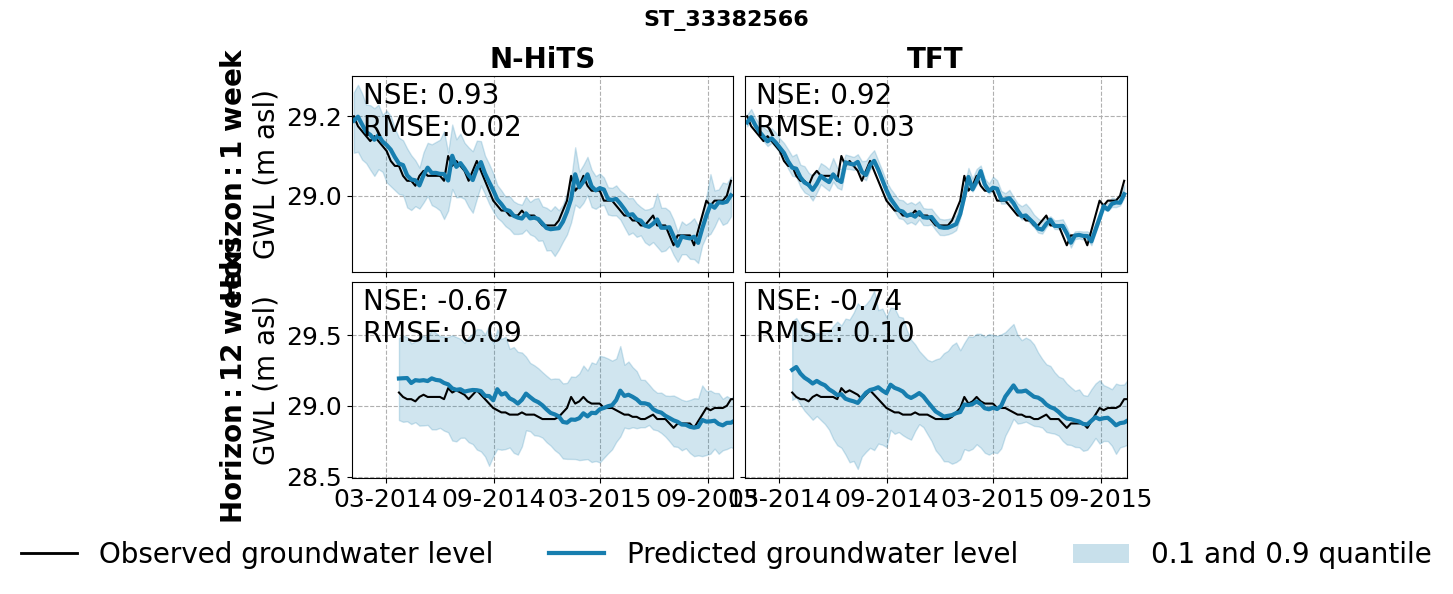

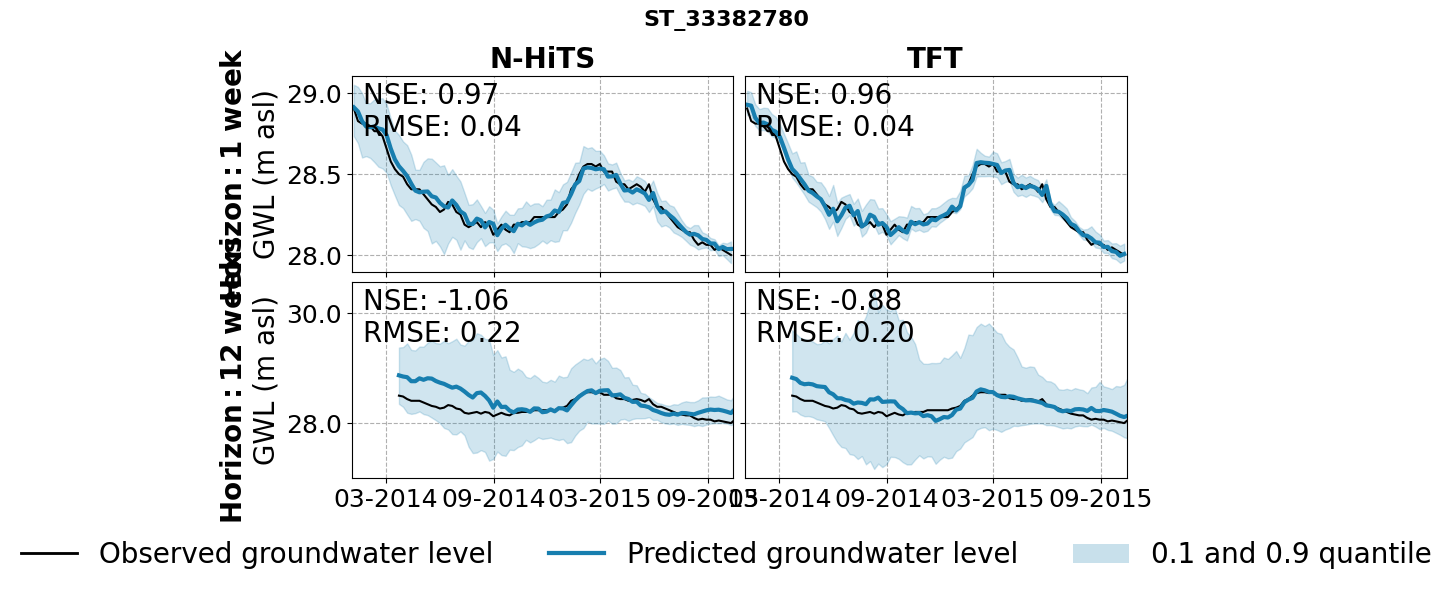

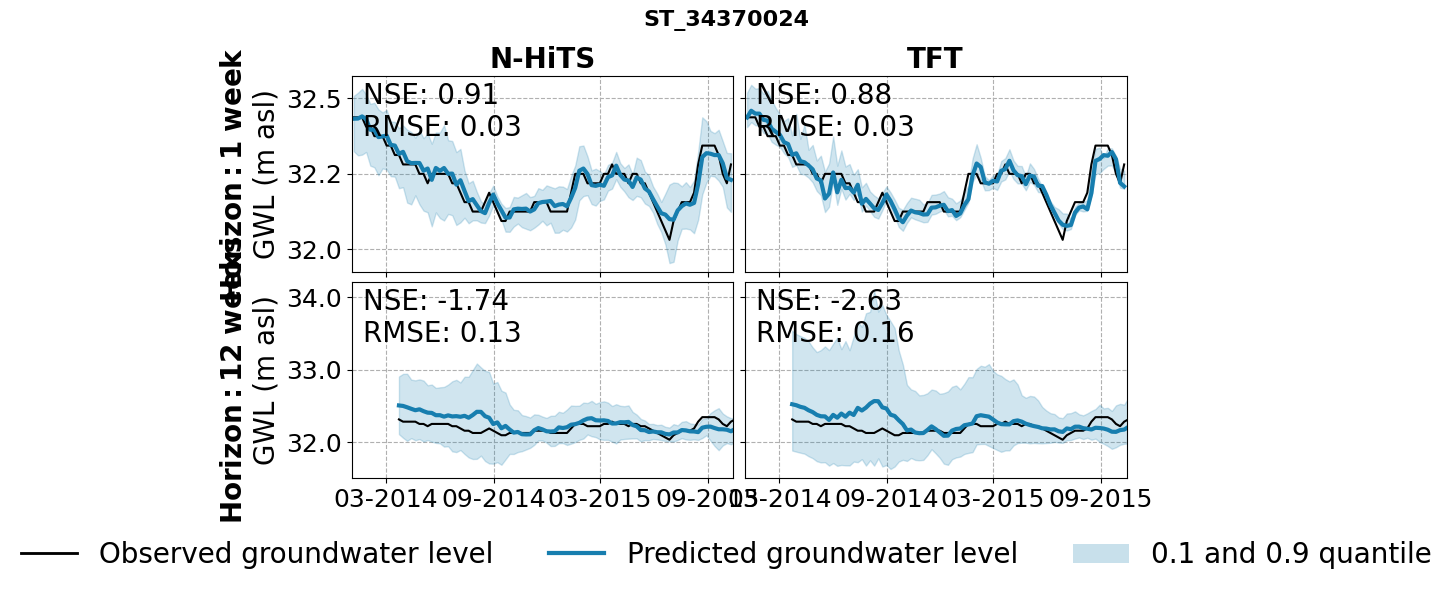

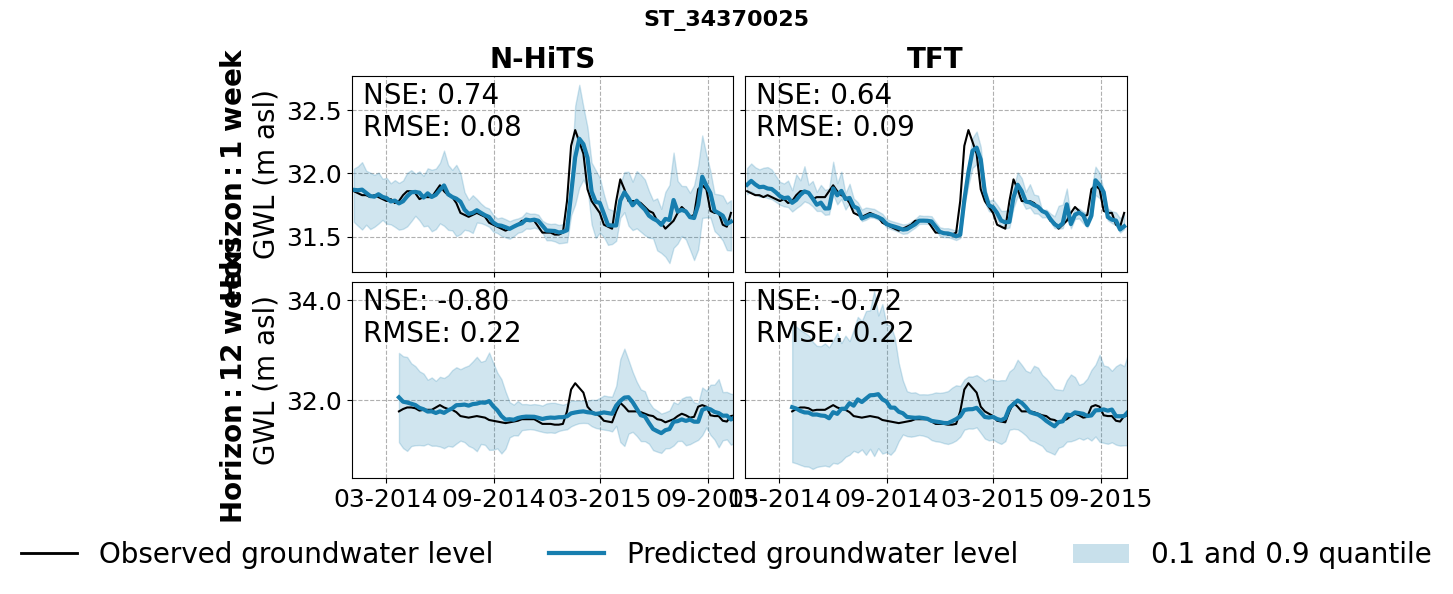

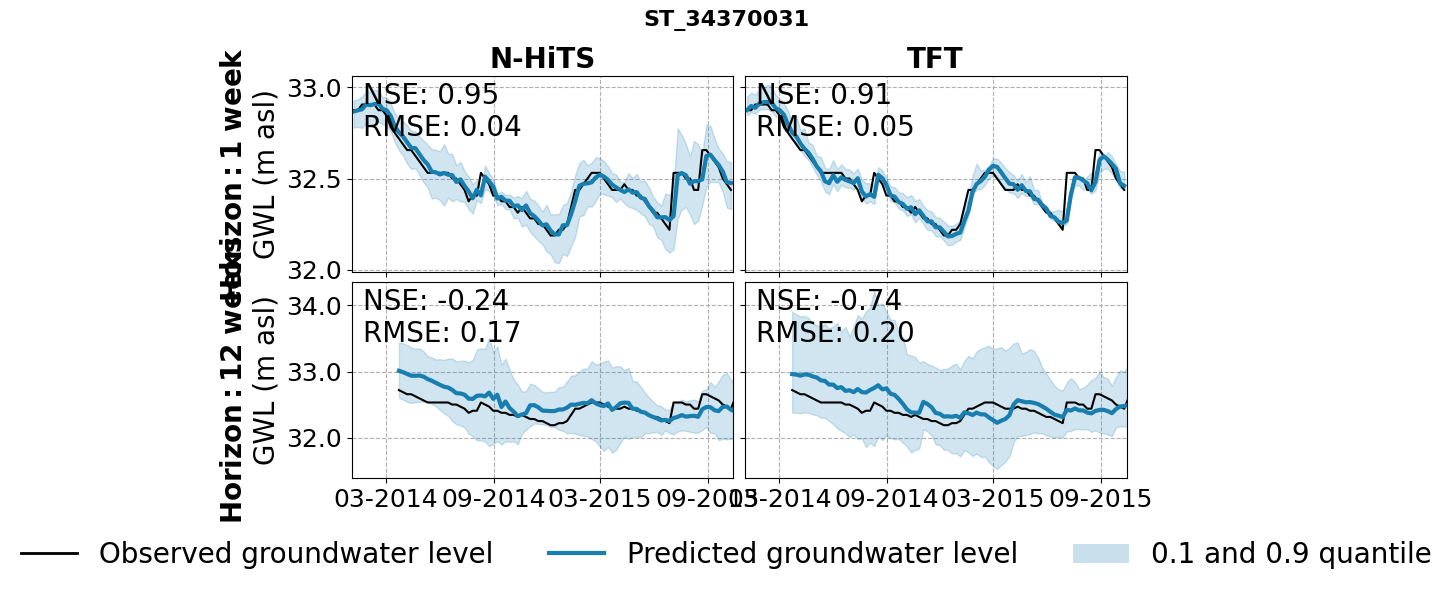

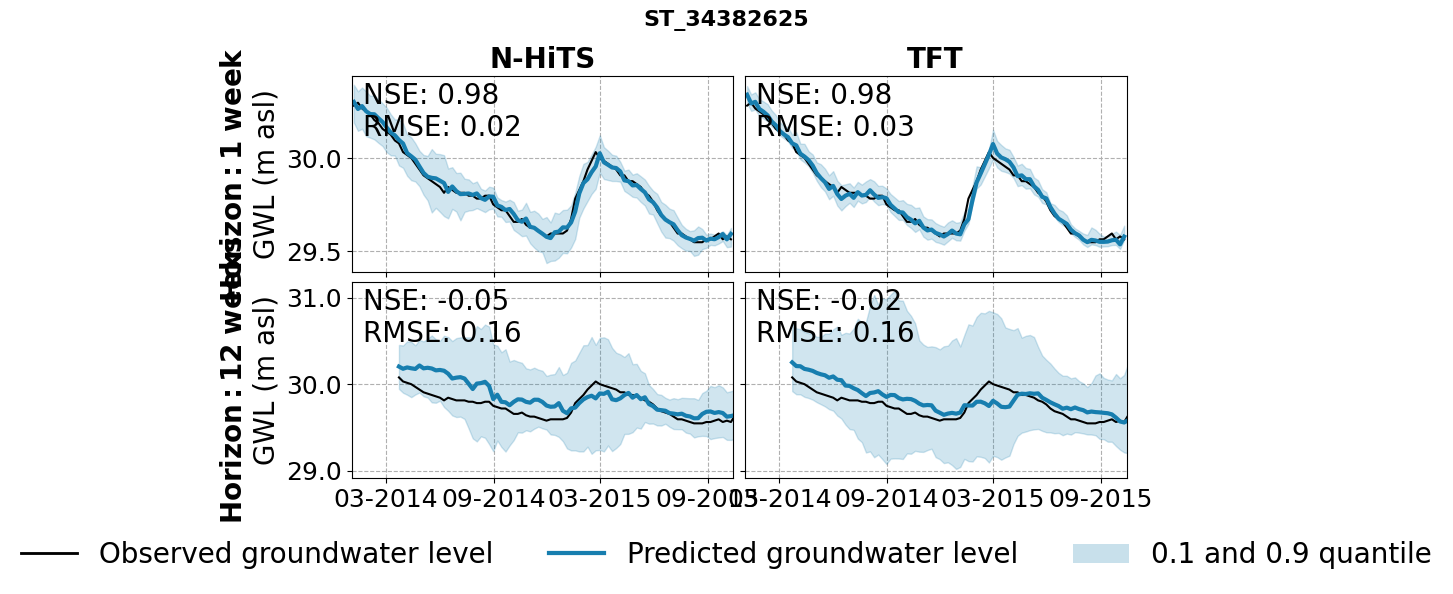

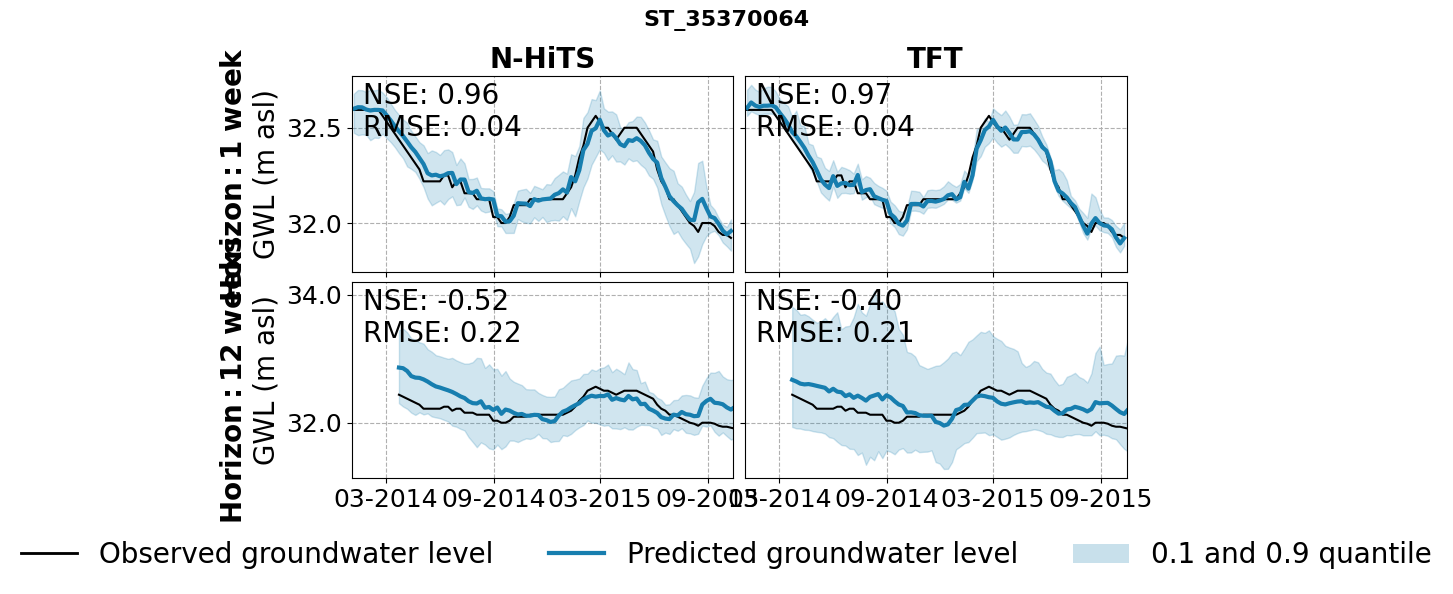

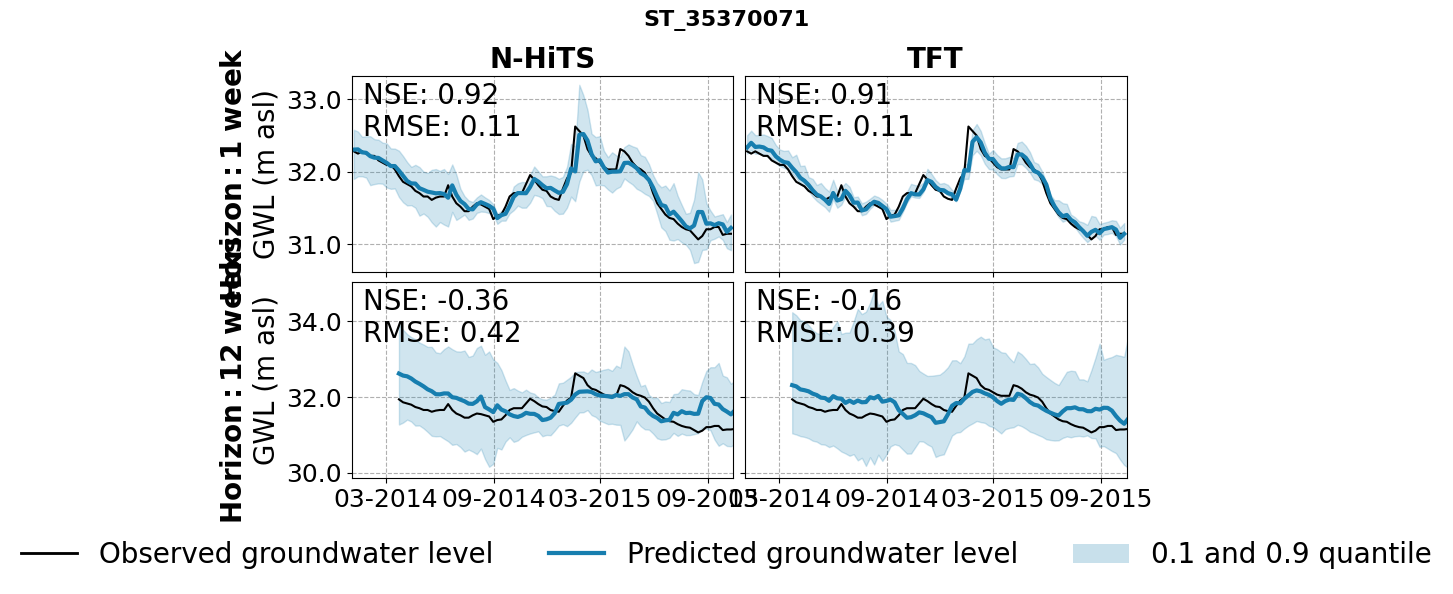

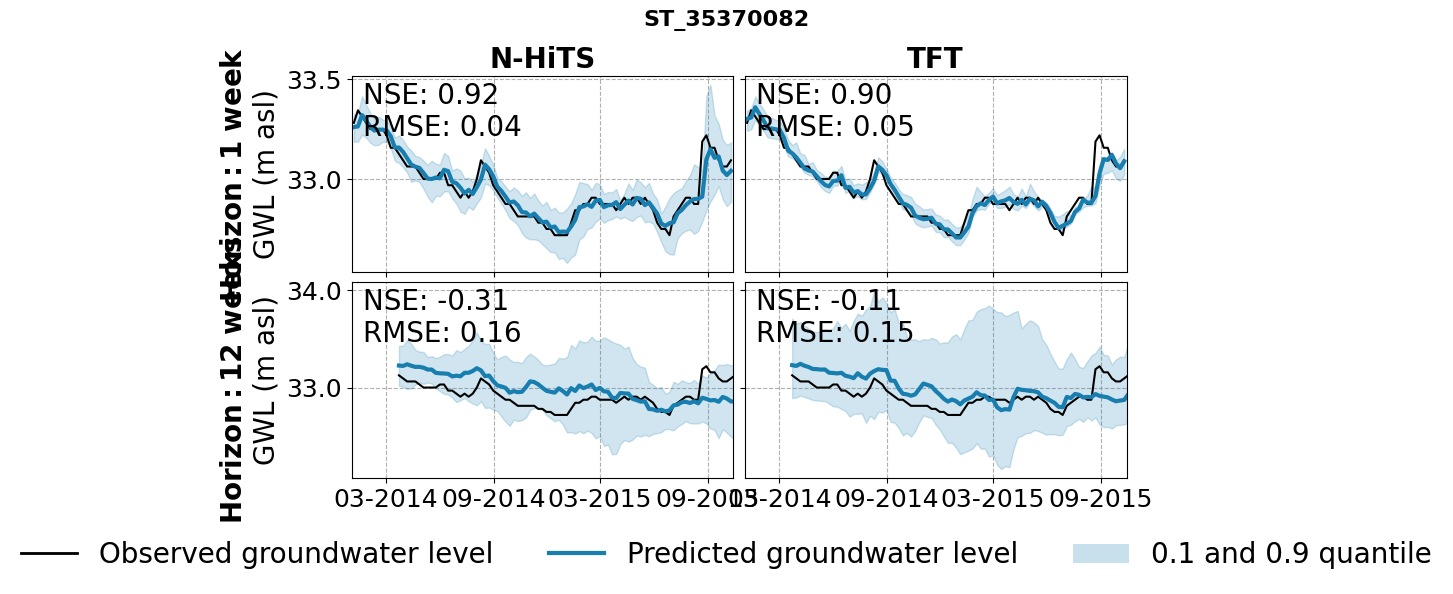

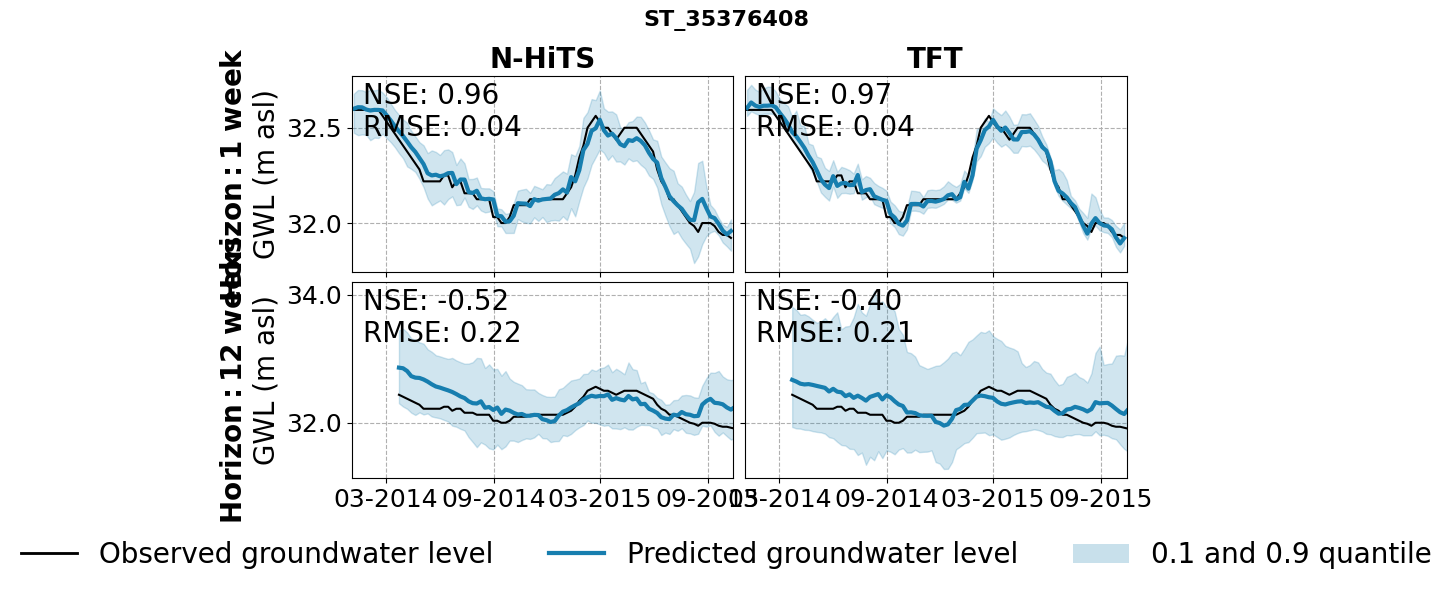

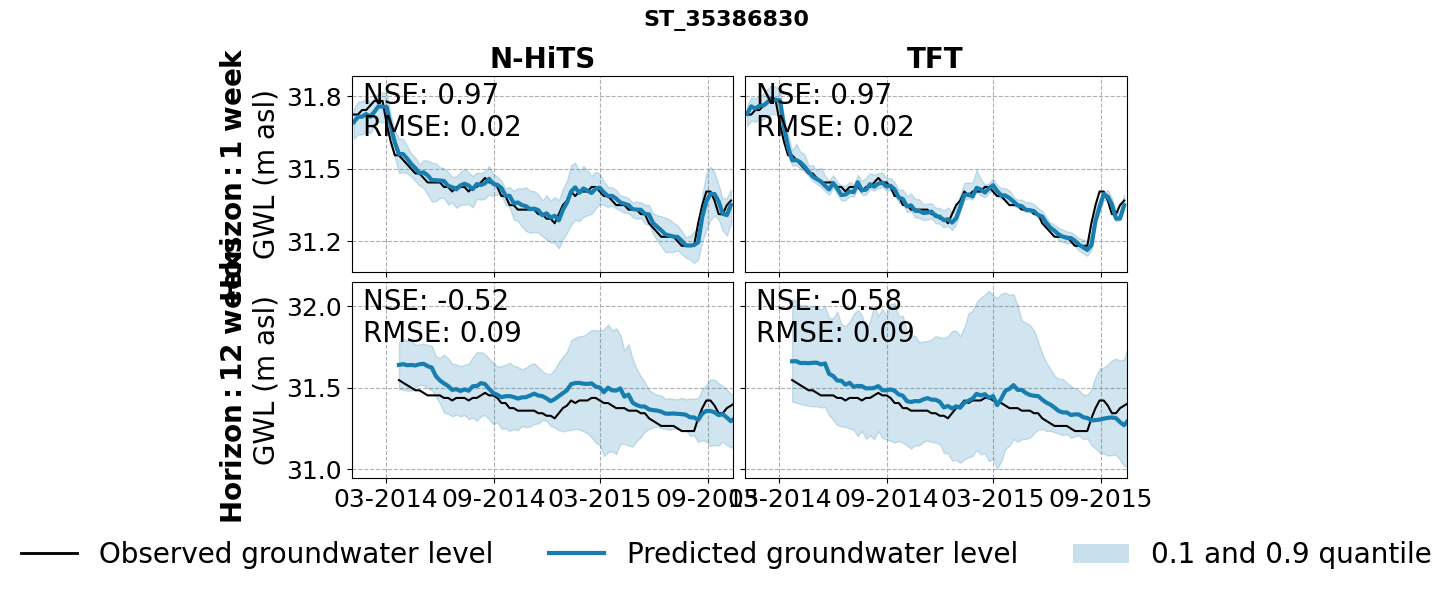

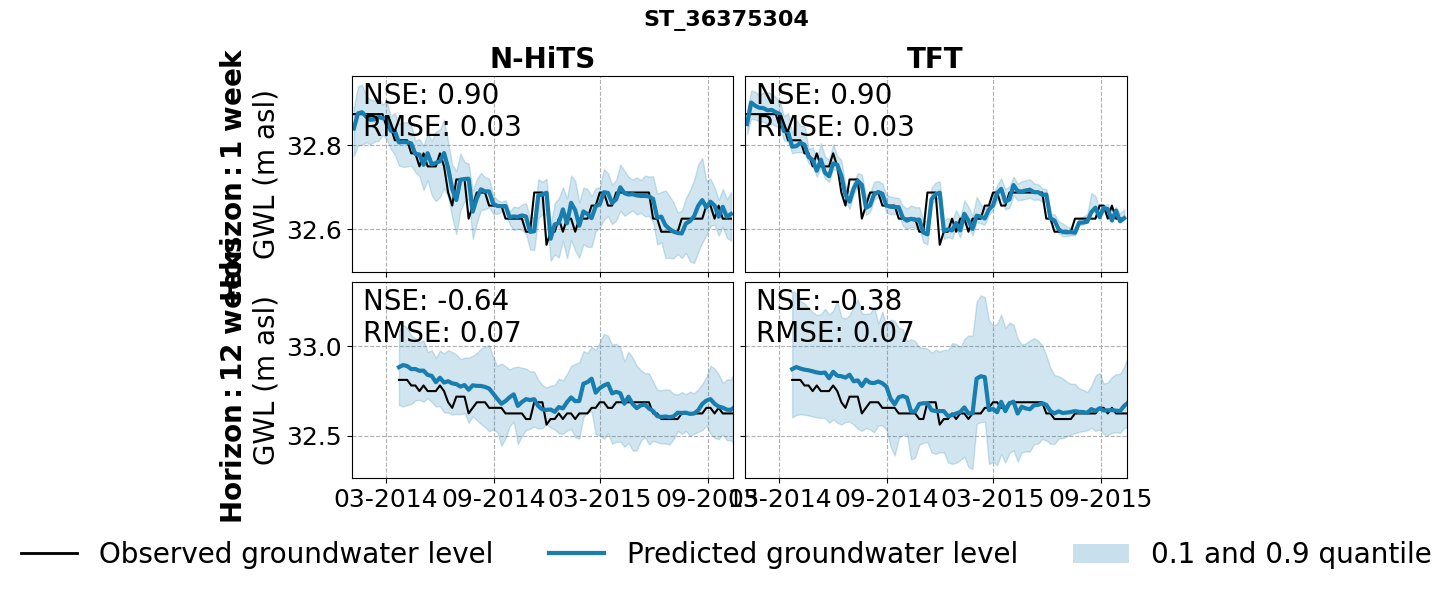

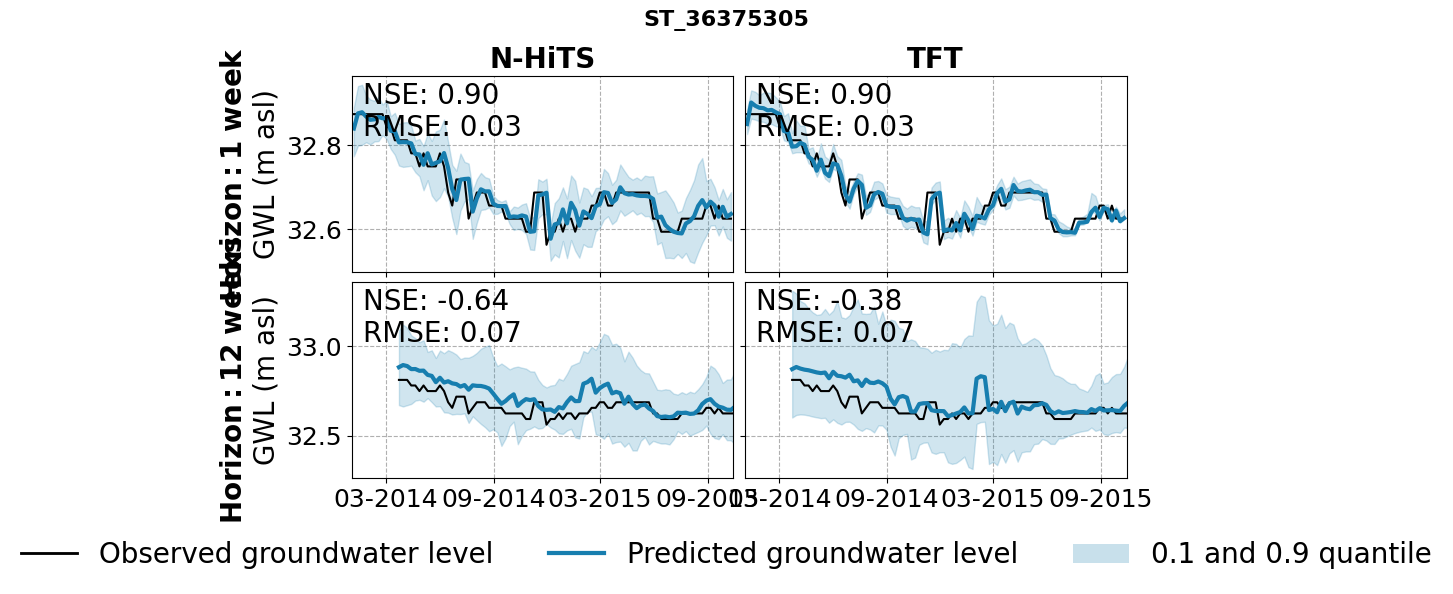

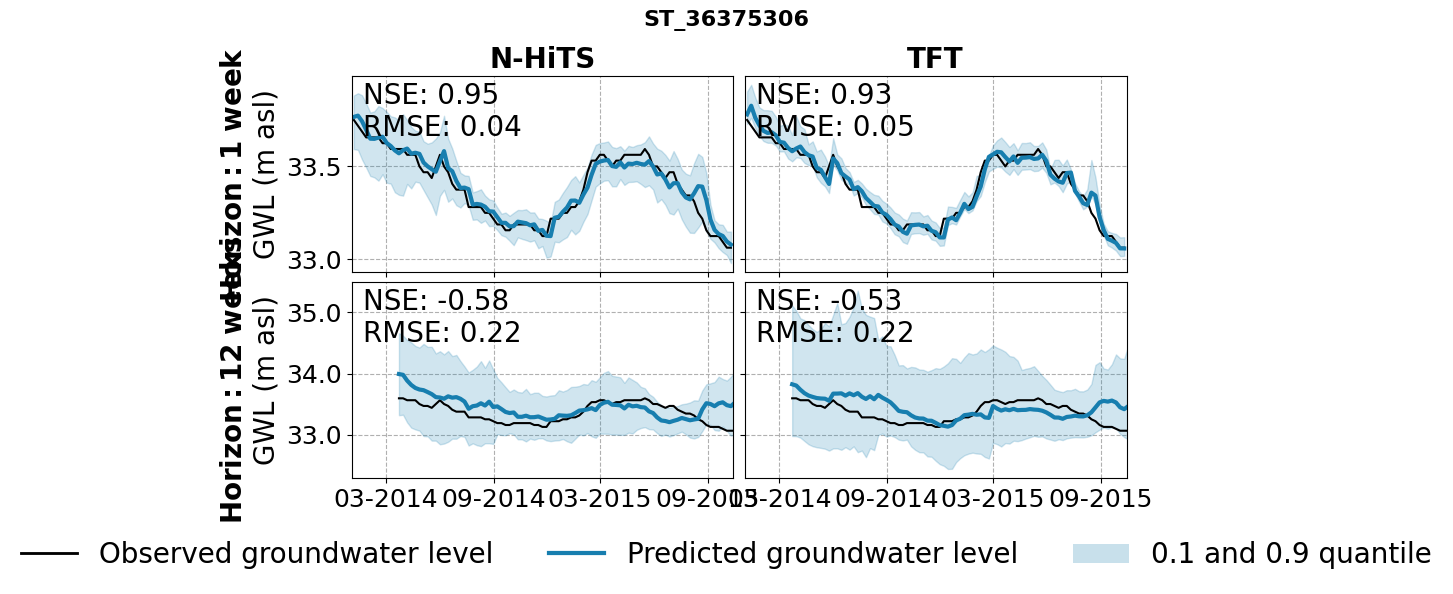

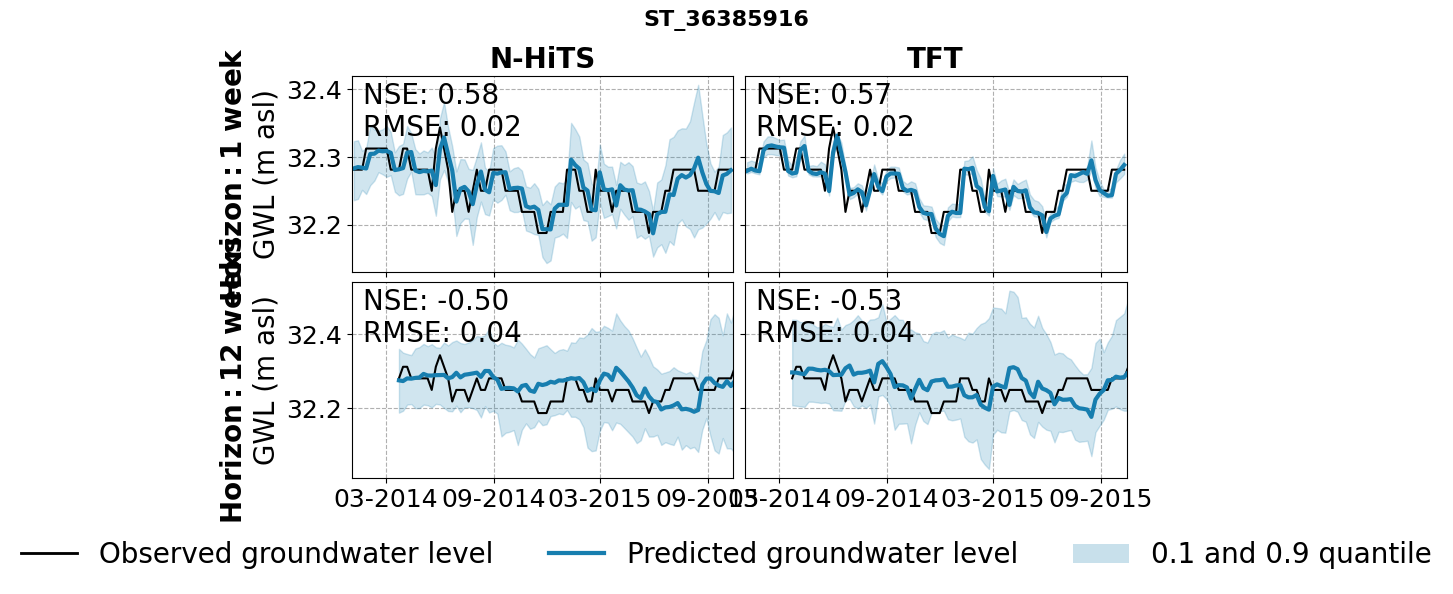

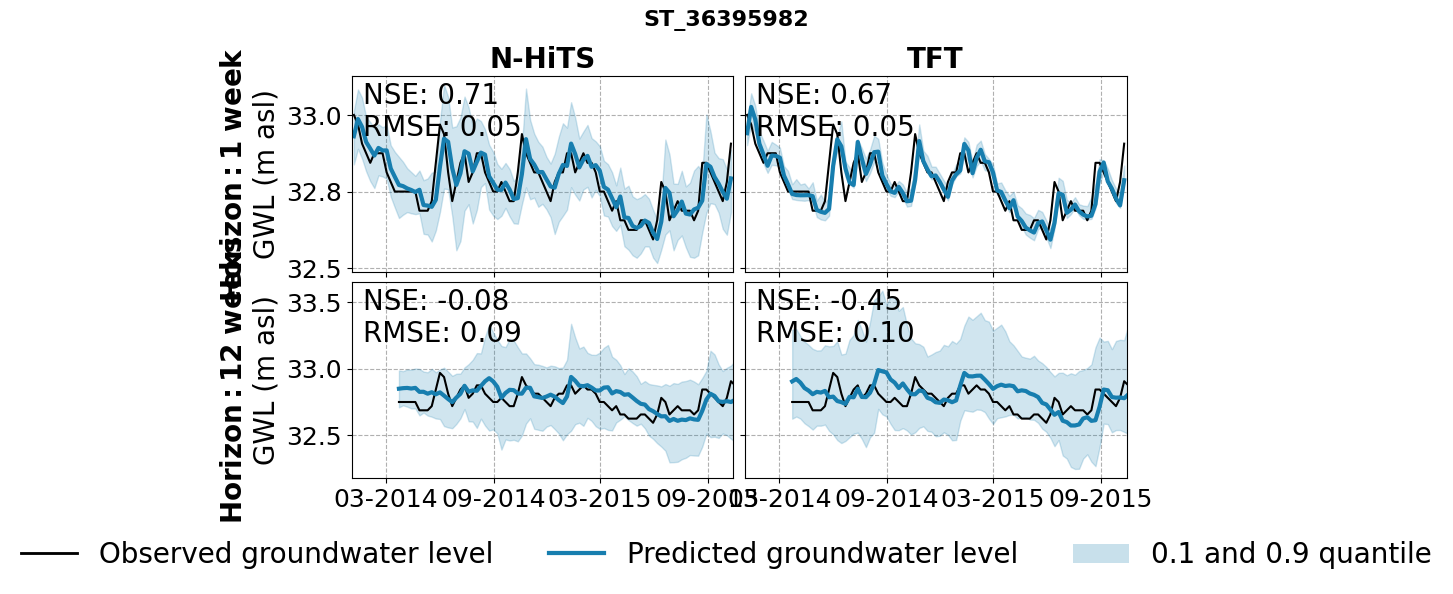

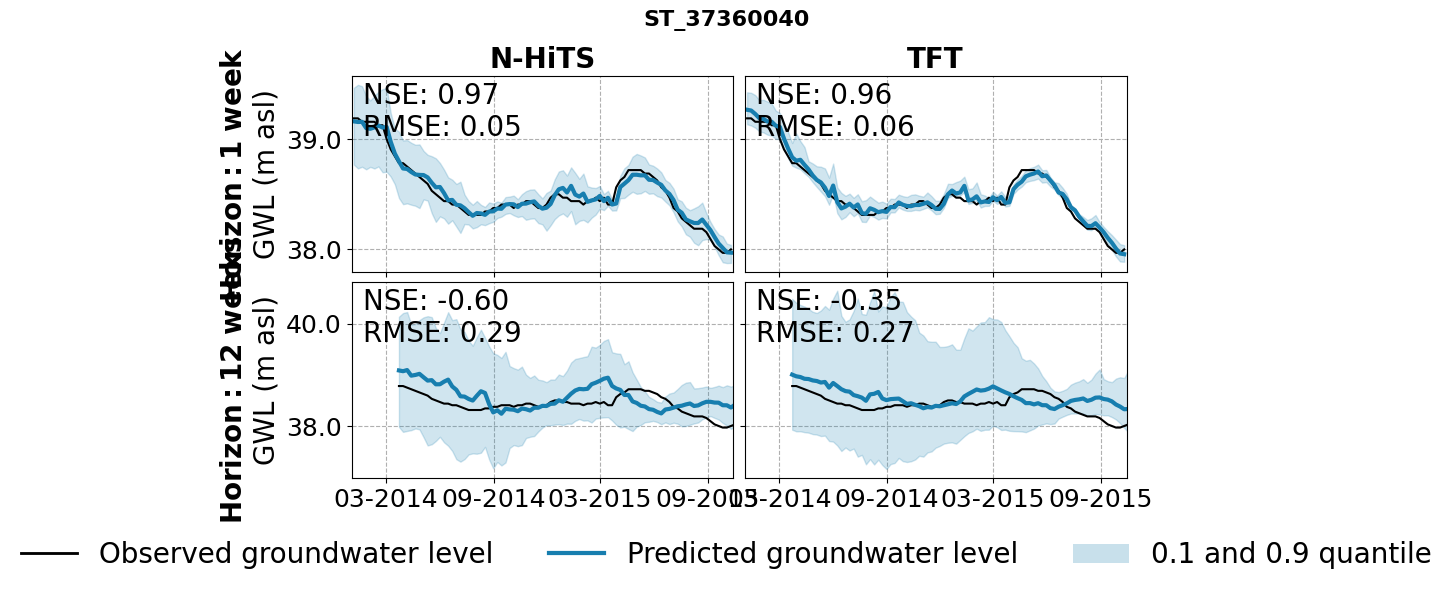

In [75]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates

sites_list = _gdf[(_gdf['proj_id'].isin(critical_ids_st)) & 
                  (_gdf['NSE'] < 0)]['proj_id']

MODEL_MAP = {
    'nhits_full': 'N-HiTS',
    'tft_full': 'TFT',}

for proj_id in sites_list:
    fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex='all', sharey='row')
    fig.suptitle(proj_id, fontsize=16, fontweight='bold')  # Adding title to the whole figure

    for c, horizon in enumerate([1, 12]):
            forecasts = forecasts_df[(forecasts_df['proj_id'] == proj_id) & (forecasts_df['horizon'] == horizon)]
            metrics = metrics_subset[(metrics_subset['proj_id'] == proj_id) & (metrics_subset['horizon'] == horizon)]
          #  print(sub, c, horizon)
            for idx, (model, sub_group) in enumerate(forecasts.groupby('model')):
                _df = sub_group.sort_values(by='time').dropna(subset=['time']).reset_index(drop=True)
                ax[c][idx].plot(_df['time'], _df['gwl'], color ='k')
                ax[c][idx].plot(_df['time'], _df['forecast'], color ='#177eaf', lw = 3)

                ax[c][idx].fill_between(_df['time'], _df['forecast_q10'], _df['forecast_q90'], color='#177eaf', alpha=.20)

                _m = metrics[metrics['model_type'] == model].iloc[0]
                ax[c][idx].text(0.03, 0.97,f"NSE: {_m['NSE']:.2f}\nRMSE: {_m['RMSE']:.2f}",
                    transform=ax[c][idx].transAxes, verticalalignment='top', horizontalalignment='left',fontsize=FONT_SIZE)

                if horizon > 1 :
                    ax[c][0].set_ylabel(f'\n' + r'$\bf{Horizon: ' + f'{horizon}' + '\ weeks}$\nGWL (m asl)', fontsize=FONT_SIZE)
                else:
                    ax[c][0].set_ylabel(f'\n' + r'$\bf{Horizon: ' + f'{horizon}' + '\ week }$\nGWL (m asl)', fontsize=FONT_SIZE)

                if c == 1:
                    ax[c][idx].xaxis.set_tick_params(labelbottom=True)
                    # ax[c][idx].xaxis.set_tick_params(which='minor', labelbottom=True)
                    ax[c][idx].set_xlabel(None)
                if c == 0: 
                    ax[c][idx].set_title(f'{MODEL_MAP[model]}', loc='center', fontsize=FONT_SIZE ,fontweight='bold')

                    #ax[c][idx].set_ylim(201.5,205)   
                ax[c][idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

                ax[c][idx].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
                ax[c][idx].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
                ax[c][idx].set_xlim(pd.Timestamp(2014, 4, 1), pd.Timestamp(2015, 10, 15))
                ax[c][idx].set_axisbelow(True)
                ax[c][idx].grid(True, linestyle='--')

            #fig.align_labels()
            fig.subplots_adjust(hspace=0.05, wspace=0.03, top=0.87, bottom=0.2)
            legend_elements = [
                Line2D([0], [0], color='k', lw=2, label='Observed groundwater level'),
                Line2D([0], [0], color='#177eaf',  lw=3, label='Predicted groundwater level'),
                Patch(facecolor='#177eaf', alpha=0.2, edgecolor=None, label='0.1 and 0.9 quantile'),
                ]
            fig.legend(handles=legend_elements,  ncols=3, edgecolor='none', fontsize = FONT_SIZE, loc= 'lower center')
        
    fig.savefig(os.path.join(SHARE_PATH,'global_mod_paper', 'figures', 'wells_paper', 'wells_st', 'wells_critical_elbe', f'{proj_id}.png'))

### Differences between _full and _diff model

In [ ]:
metrics_subset_h12 = metrics_subset[metrics_subset['horizon']==12][['proj_id', 'horizon', 'model_type', 'NSE', 'RMSE']]

# Bring to wide format
# Substract columns and look for NSE differences > 0.1
metrics_subset_h12 = metrics_subset_h12.pivot(index='proj_id', columns='model_type', values='NSE')
metrics_subset_h12['NSE_diff_nhits'] = metrics_subset_h12['nhits_full'] - metrics_subset_h12['nhits_dyn']
metrics_subset_h12['NSE_diff_tft'] = metrics_subset_h12['tft_full'] - metrics_subset_h12['tft_dyn']

# Interesting findings:
# - There are 101 sites, where the addition of static information 
# actually decreased a decent model performace (i.e. N-HiTS_dyn NSE >= 0.5)
# metrics_subset_h12[(metrics_subset_h12['dyn'] >= 0.5) & (metrics_subset_h12['NSE_diff'] <= -0.1)]
sites_worse_nhits = metrics_subset_h12[(metrics_subset_h12['nhits_dyn'] >= 0.5) & (metrics_subset_h12['NSE_diff_nhits'] <= -0.1)].index

# - There are 285 sites where the addition of static information improved the model performance of 0.1 to a decent performing model (i.e. NSE N-HiTS_full >= 0.5)
# metrics_subset_h12[(metrics_subset_h12['full'] >= 0.5) & (metrics_subset_h12['NSE_diff'] >= 0.1)]
sites_improv_nhits = metrics_subset_h12[(metrics_subset_h12['nhits_full'] >= 0.5) & (metrics_subset_h12['NSE_diff_nhits'] >= 0.1)].index

# TFT

# 180
sites_worse_tft = metrics_subset_h12[(metrics_subset_h12['tft_dyn'] >= 0.5) & (metrics_subset_h12['NSE_diff_tft'] <= -0.1)].index

# 241
sites_improv_tft = metrics_subset_h12[(metrics_subset_h12['tft_full'] >= 0.5) & (metrics_subset_h12['NSE_diff_tft'] >= 0.1)].index

In [ ]:
gdf_improv_nhits = gdf[(gdf['horizon']==12) & (gdf['model_type']=='nhits_full') & (gdf['proj_id'].isin(sites_improv_nhits))]
gdf_worse_nhits = gdf[(gdf['horizon']==12) & (gdf['model_type']=='nhits_dyn') & (gdf['proj_id'].isin(sites_worse_nhits))]

#### Sites with model performance increase after adding static information

TODO 
- Statistical tests for all static variables

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5.5, 4.5))
germany_shp_df.plot(ax=axes, color='grey', alpha=.3, edgecolor="face", linewidth=0.4, aspect=1.5)

# Plot points from GeoDataFrame gdf with color based on the 'NSE' column
gdf_improv_nhits.plot(ax=axes, marker='o', markersize=10, alpha=1, column='NSE', legend=True, cmap='cividis')

# Add axis labels and caption
axes.set_xlabel('Longitude', fontsize=13, fontweight='bold')
axes.set_ylabel('Latitude', fontsize=13, fontweight='bold')
# axes.set_title('Sites with model performance improvement > 0.1 NSE \n after adding static information (N-HiTS_full)')

plt.tight_layout()
plt.show()

In [ ]:
# Quick data overview of the static features o the sites where model performance increased
stat_cols = ['twi',
    'gw_recharge',
    'landform_sha10km',
    'eumohp_dsd1',
    'eumohp_lp1',
    'eumohp_sd1',
    'elevation',
    'hyraum_gr',
    'land_cover', 
    'aquifer_type', 
    'permeability_coef',
    'soil_texture']

static_improve = test_df_in_sample[test_df_in_sample['proj_id'].isin(sites_improv)][['proj_id'] + stat_cols].drop_duplicates(subset=['proj_id'])

In [ ]:
# Numerical columns
static_improve[['twi',
                'gw_recharge',
                'landform_sha10km',
                'eumohp_dsd1',
                'eumohp_lp1',
                'eumohp_sd1',
                'elevation']].plot(kind='kde', 
                                   subplots=True,
                                   layout=(7, 1),
                                   figsize=(10, 7*5), 
                                   sharey=False,
                                   sharex=False)

In [ ]:
# Possibly interesting: 
# - elevation: lower than in the whole dataset (mean: 113,5 vs 146,7; 75 percentile: 94.9 vs. 162.1)
# - eumohp_sd1: higher for the sites with static information (mean: 1754,8 vs 1022,9; 75 percentile 2407 vs 1426)
static_improve[['twi',
                'gw_recharge',
                'landform_sha10km',
                'eumohp_dsd1',
                'eumohp_lp1',
                'eumohp_sd1',
                'elevation']].describe()

In [ ]:
# Comparison to the full dataset
test_df_in_sample[['twi',
                   'gw_recharge',
                   'landform_sha10km',
                   'eumohp_dsd1',
                   'eumohp_lp1',
                   'eumohp_sd1',
                   'elevation']].describe()

In [ ]:
static_improve[['hyraum_gr',
                'land_cover', 
                'aquifer_type', 
                'permeability_coef',
                'soil_texture']].describe()

In [ ]:
test_df_in_sample[['hyraum_gr',
                   'land_cover', 
                   'aquifer_type', 
                   'permeability_coef',
                   'soil_texture']].describe()

#### Sites with performance decline with static information

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5.5, 4.5))
germany_shp_df.plot(ax=axes, color='grey', alpha=.3, edgecolor="face", linewidth=0.4, aspect=1.5)

# Plot points from GeoDataFrame gdf with color based on the 'NSE' column
gdf_worse.plot(ax=axes, marker='o', markersize=10, alpha=1, column='NSE', legend=True, cmap='cividis')

# Add axis labels and caption
axes.set_xlabel('Longitude', fontsize=13, fontweight='bold')
axes.set_ylabel('Latitude', fontsize=13, fontweight='bold')
axes.set_title('Sites with model performance decline > 0.1 NSE \n after adding static information (N-HiTS_dyn)')

plt.tight_layout()
plt.show()

In [ ]:
static_worse = test_df_in_sample[test_df_in_sample['proj_id'].isin(sites_worse)][['proj_id'] + stat_cols].drop_duplicates(subset=['proj_id'])

In [ ]:
# Numerical columns
static_worse[['twi',
              'gw_recharge',
              'landform_sha10km',
              'eumohp_dsd1',
              'eumohp_lp1',
              'eumohp_sd1',
              'elevation']].plot(kind='kde', 
                                 subplots=True,
                                 layout=(7, 1),
                                 figsize=(10, 7*5),
                                 sharex=False,
                                 sharey=False)

In [ ]:
static_worse[['twi',
              'gw_recharge',
              'landform_sha10km',
              'eumohp_dsd1',
              'eumohp_lp1',
              'eumohp_sd1',
              'elevation']].describe()

### Density plot with error estimate

In [ ]:
nhits_metrics_agg['init'] = 'median_agg'
nhits_metrics = pd.concat([nhits_metrics, nhits_metrics_agg])
nhits_metrics = nhits_metrics[nhits_metrics['NSE']>-1]

In [ ]:
nhits_metrics[nhits_metrics['horizon']==12].groupby(['model_type', 'init'])['NSE'].describe()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Assuming nhits_metrics is your DataFrame
# Define MODEL_TYPE_ls and other necessary variables

horizons = [1, 12]
p = palette = sns.color_palette("colorblind")

fig, ax = plt.subplots(2, 2, figsize=(18, 5), sharey=True)

for j, model_type in enumerate(MODEL_TYPE_ls):
    for i, horizon in enumerate(horizons):
        metric = 'NSE'
        subset_df = nhits_metrics[(nhits_metrics['horizon'] == horizon) & (nhits_metrics['model_type'] == model_type)]

        # Get unique 'init' values for the current subset
        unique_inits = subset_df['init'].unique()

        for init in unique_inits:
            x = subset_df[subset_df['init'] == init][metric].replace([np.inf, -np.inf], np.nan).dropna().values
            median = np.median(x)
            x_d = np.linspace(-1, 4, 2000)

            kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
            kde.fit(x[:, None])
            logprob = kde.score_samples(x_d[:, None])
            y_d = np.exp(logprob)

            if metric == 'NSE':
                y_d *= 2
                
            line_thickness = 1
            if init == 'median_agg':
                line_thickness = 2

            ax[j, i].plot(x_d, y_d, label=f'{model_type}_{init}', lw=line_thickness)
            ax[j, i].set_title(f'N-HiTS_{model_type} horizon {horizon} w', fontsize=16, fontweight='bold', loc='center')

            # Setting tighter x-axis limits
            ax[j, i].set_xlim((np.min(x), np.max(x)))

            # Make background transparent
            rect = ax[j, i].patch
            rect.set_alpha(0)

            # Remove borders, axis ticks, and y labels, set x labels
            ax[j, i].set_yticklabels([])
            ax[j, i].grid(False)
            ax[j, i].set_xlabel(metric)

plt.show()